In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

titanic = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
titanic.describe(include='all').T
# There are some missing values in Age.
# There are also missing categories in Cabin and Embarked.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [3]:
titanic.shape

(891, 12)

In [4]:
titanic.duplicated().sum()
# no duplicate values.

0

## Let's create a user defined function to make plotly histo/boxplots.

In [5]:
#Plotly Histobox! plotly.graph_objects
def histobox(data,x,bins=200):
    plot = make_subplots(rows=2,
                         cols=1,
                         row_heights=[0.2, 0.8],
                         shared_xaxes=True,
                        )
    plot.add_trace(
        go.Box(x=data[x],
               line={'color': '#1F2022'},
               fillcolor='orange',name='Boxplot'),
        row=1,col=1
    )

    plot.add_trace(
        go.Histogram(x=data[x],
                    marker = {'color': '#088F8F'},
                    nbinsx=bins,name='Histogram'
                    ),
        row=2,col=1
    )

    plot.update(layout_showlegend=False)
    plot.update_layout(width=800,height=400,margin=dict(l=0, r=0, t=40, b=40),title='<b>'+x+'</b>',title_x=0.514)
    plot.add_vline(x=data[x].mean(), line_width=1, line_dash="dash", line_color="#355E3B")
    plot.show()

In [6]:
for entry in list(titanic.describe().columns):
    histobox(titanic,entry,bins=100)

## Our target variable, Survived, is not imbalanced. We will not be performing a SMOTE or RUS sampling.

#### Let's drop PassengerId as it is simply an index.

In [7]:
titanic.drop('PassengerId',axis=1,inplace=True)

## Let's also check the categorical variables.

In [8]:
list(titanic.columns)


['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [9]:
# Use this for relevant categorical data. plotly.express
def countplot_plotly(data,x,palette='coolwarm',mult=2):
    if len(list(data[x].unique())) > 20:
        plot = px.bar(pd.DataFrame(data[x].value_counts()).reset_index().rename(columns={'index':x,x:'Count'}),
              x=x,
              y='Count',
              color_discrete_sequence=[sns.color_palette(palette,(mult*len(list(data[x].unique())))).as_hex()])
        plot.update_xaxes(showticklabels=False)
        plot.update_layout(width=900,height=500,
                           margin=dict(l=0, r=100, t=40, b=0),
                           yaxis_title=None,xaxis_title=None,
                           title='<b>'+x+'</b>',title_x=0.426)
        plot.show()
    
    else:
        plot = px.bar(pd.DataFrame(data[x].value_counts()).reset_index().rename(columns={'index':x,x:'Count'}),
              x=x,
              y='Count',
              color_discrete_sequence=[sns.color_palette(palette,(mult*len(list(data[x].unique())))).as_hex()])
        plot.update_layout(width=900,height=500,
                           margin=dict(l=0, r=100, t=40, b=0),
                           yaxis_title=None,xaxis_title=None,
                           title='<b>'+x+'</b>',title_x=0.426)
        plot.show()

In [10]:
for entry in list(titanic.describe(include='object').columns):
    countplot_plotly(titanic,entry)

In [11]:
titanic.drop('Name',axis=1,inplace=True)
test.drop('Name',axis=1,inplace=True)

In [12]:
titanic.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)

## Checking to see how bad our missing values are.
    Age, Cabin, and Embarked

In [13]:
titanic[titanic['Age'].isnull()]['Parch'].value_counts()

0    157
2     12
1      8
Name: Parch, dtype: int64

#### It appears that null age values are not affected by Parent or Child counts.

In [14]:
titanic[titanic['Cabin'].isnull()]['Pclass'].value_counts()

3    479
2    168
1     40
Name: Pclass, dtype: int64

#### Similarly, missing Cabin labels are not affected by economic status.

In [15]:
titanic[titanic['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,80.0,B28,NaN
829,1,1,female,62.0,0,0,80.0,B28,NaN


#### There are only 2 missing values for Embarked, and both come from the same Cabin.

## The worst of the missing values is easily Cabin. 77.1% of the values are missing.

In [16]:
titanic['Cabin'].isnull().sum()/891*100

77.10437710437711

## Effectively, Cabin is a useless column to us. Any attempt at an imputation will result in false information as many class 3 passengers likely do not have a cabin because of economic status, not because of missing data.

## We will drop Cabin.

In [17]:
titanic.drop('Cabin',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

## The rest of the columns will be imputed after the train/test split.

In [18]:
titanic.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Let's transform Sex and Embarked into numericals for ease of modeling.
    We will be dummy encoding Embarked later, we are Label Encoding it for imputing purposes.

In [19]:
sex = {'male':0,'female':1}
titanic['Sex'] = titanic['Sex'].map(sex)
test['Sex'] = test['Sex'].map(sex)
embark = {'C':0,'Q':1,'S':2}
titanic['Embarked'] = titanic['Embarked'].map(embark)
test['Embarked'] = test['Embarked'].map(embark)

In [20]:
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,2.0
887,1,1,1,19.0,0,0,30.0000,2.0
888,0,3,1,NaN,1,2,23.4500,2.0
889,1,1,0,26.0,0,0,30.0000,0.0


## Let's check a quick correlation pairplot and heatmap.

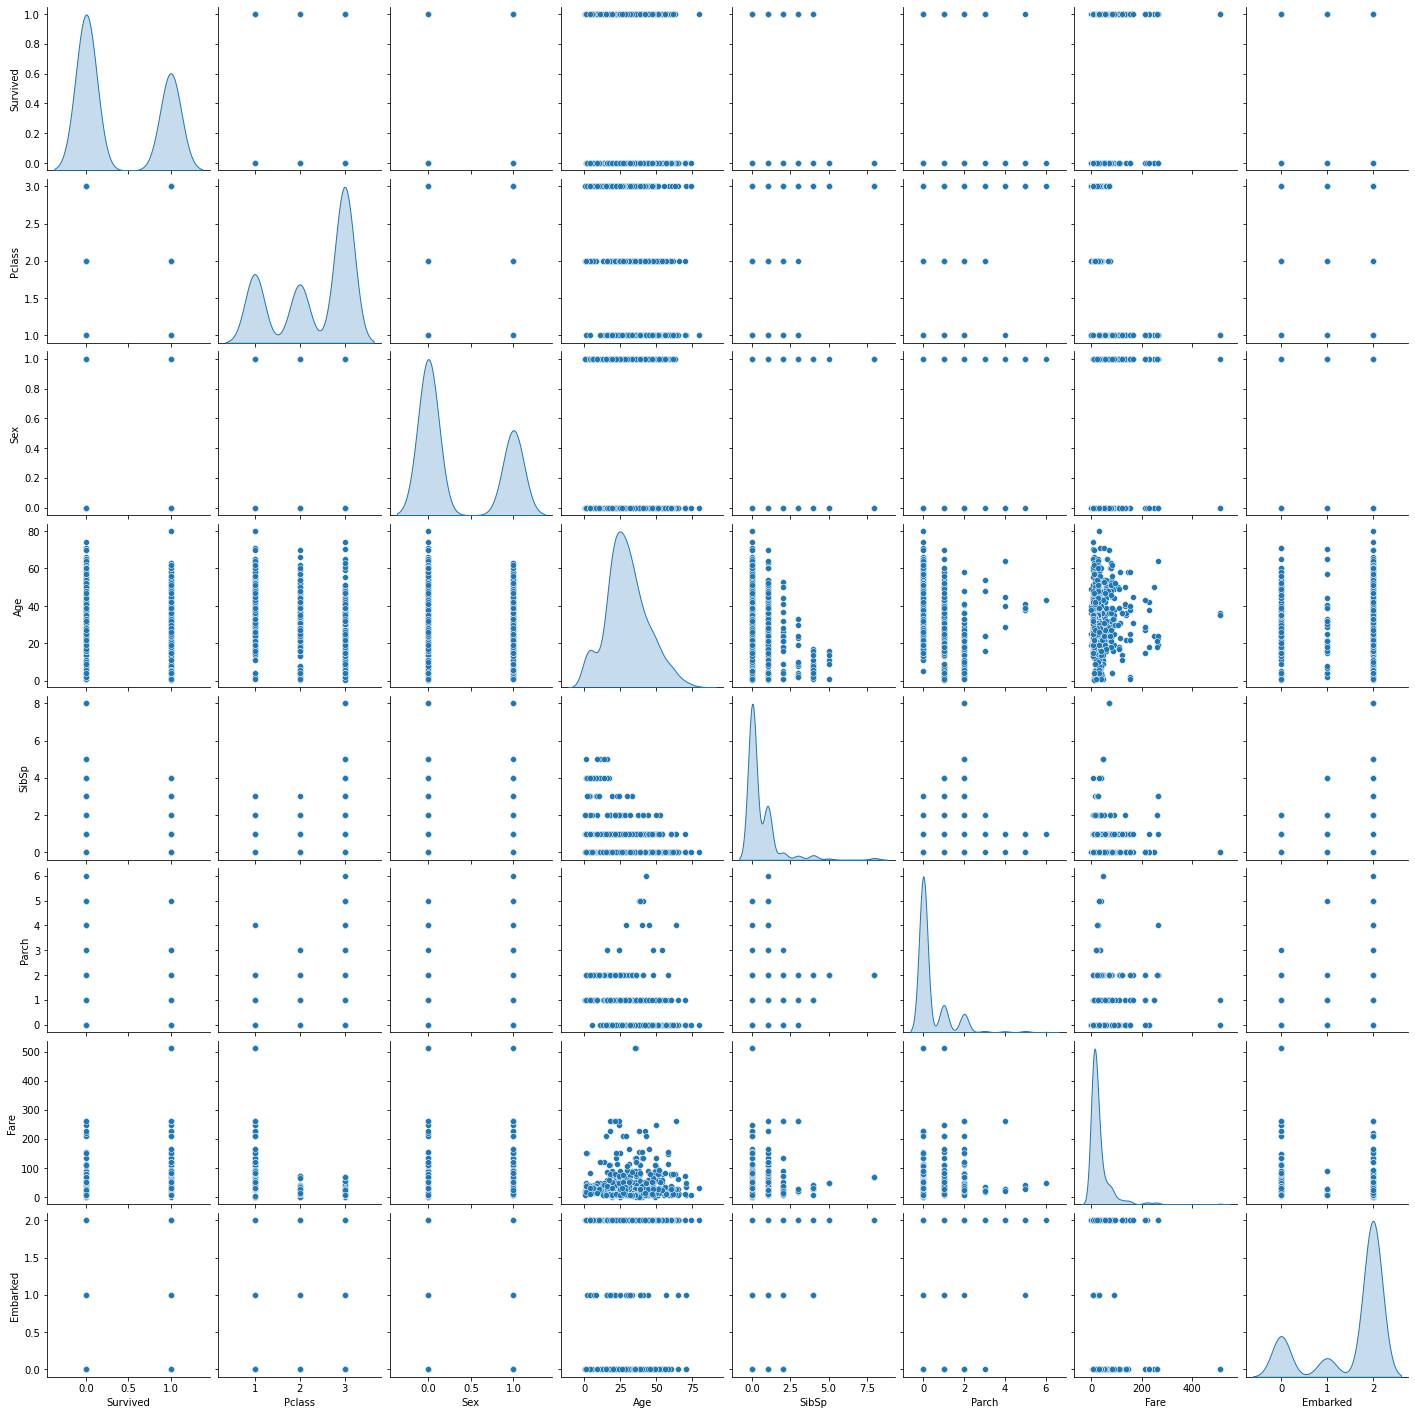

In [21]:
sns.pairplot(titanic,diag_kind='kde');

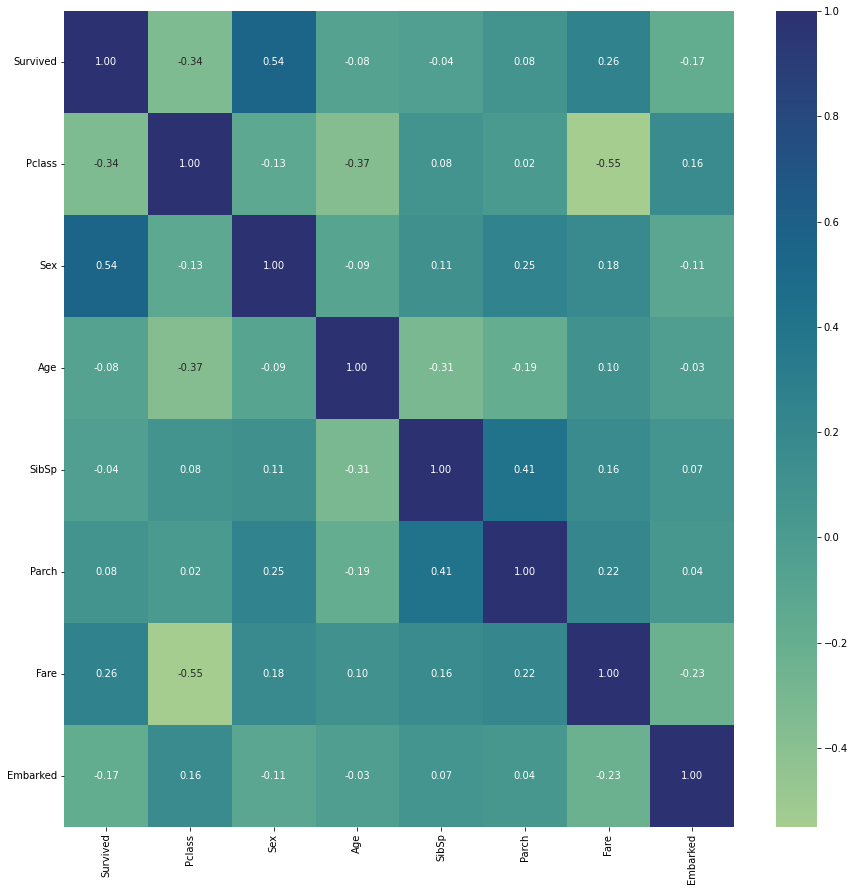

In [22]:
sns.heatmap(titanic.corr(),annot=True,fmt='.2f',cmap='crest')
plt.gcf().set_size_inches(15,15)

## The highest correlations with the dependent variable are Pclass, Sex, and Fare. As Pclass goes up, survival tends downward, as Fare goes up, survival tends upward, and females tend to survive more often.
## Most of our numerical variables are not continuous, so a pairplot tells us almost nothing. There is a fairly large outlier in Fare, however; let's check that really quick.

In [23]:
def ratio_outside_1pt5_IQR(data,column):
    length = 1.5 * np.diff(np.quantile(data[column][data[column].notnull()],[.25,.75]))
    return np.mean(np.abs(list(data[column])-np.median(data[column]))>length)

In [24]:
ratio_outside_1pt5_IQR(titanic,'Fare')

0.1840628507295174

## That's a decent amount of points outside of 1.5x IQR. Let's check a more broad 6x IQR.

In [25]:
def six_iqr(data,column):
    Sixiqr=6 * np.diff(np.quantile(data[column][data[column].notnull()],[.25,.75]))
    return np.mean(np.abs(list(data[column])-np.median(data[column]))>Sixiqr)

In [26]:
def six_iqr_outlier_list(data,column):
    outliers=data.loc[np.abs(data[column]-data[column].median())>
    6*np.diff(np.quantile(data[column][data[column].notnull()],[.25,.75]))[0],column]
    return outliers

In [27]:
six_iqr(titanic,'Fare')

0.028058361391694726

In [28]:
six_iqr_outlier_list(titanic,'Fare').index.tolist()

[27,
 88,
 118,
 258,
 268,
 299,
 311,
 318,
 332,
 341,
 377,
 380,
 438,
 527,
 557,
 609,
 679,
 689,
 700,
 716,
 730,
 737,
 742,
 779,
 856]

## We will keep these index values in mind and impute them with their respective minimums and maximums once we train/val split.

## One more histobox check before we move on...

In [29]:
for entry in list(titanic.columns):
    histobox(titanic,entry,bins=100)

---
---
---

# Train/Val/Test preparation

In [30]:
modeltest = test.copy()
test = test['PassengerId'] #preparation for the final csv file.
modeltest.drop(['PassengerId'],axis=1,inplace=True)

In [31]:
modeltest.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [32]:
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

## Embarked will be the only Categorical, dummy encoded after a KNN Impute.

In [33]:
X = titanic.drop('Survived',axis=1)
y = titanic['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y
)

In [34]:
numerical_list=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_list=['Embarked']

In [35]:
X_train_num = X_train[numerical_list]
X_val_num = X_val[numerical_list]
X_test_num = modeltest[numerical_list]

X_train_cat = X_train[categorical_list]
X_val_cat = X_val[categorical_list]
X_test_cat = modeltest[categorical_list]

In [36]:
list_of_dicts = [embark]
Dummy=['Embarked']
def categorical_imputing_WITH_dummies(X_train_cat, X_val_cat, X_test_cat):
    cat_pipeline = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=5)) #change n_neighbors as needed
    X_train_cat = pd.DataFrame(cat_pipeline.fit_transform(X_train_cat),columns=categorical_list)
    X_val_cat = pd.DataFrame(cat_pipeline.transform(X_val_cat),columns=categorical_list)
    X_test_cat = pd.DataFrame(cat_pipeline.transform(X_test_cat),columns=categorical_list)

    def inverse_mapping(x, y):
        inv_dict = {v: k for k, v in x.items()}
        X_train_cat[y] = np.round(X_train_cat[y]).map(inv_dict).astype("category")
        X_val_cat[y] = np.round(X_val_cat[y]).map(inv_dict).astype("category")
        X_test_cat[y] = np.round(X_test_cat[y]).map(inv_dict).astype("category")

    count=0
    for item in list_of_dicts:
        inverse_mapping(item,Dummy[count])
        count = count+1

    X_train_cat = pd.get_dummies(X_train_cat, drop_first=False)
    X_val_cat = pd.get_dummies(X_val_cat, drop_first=False)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first=False)

    return [X_train_cat, X_val_cat, X_test_cat]

[X_train_cat, X_val_cat, X_test_cat] = categorical_imputing_WITH_dummies(X_train_cat, X_val_cat, X_test_cat)

## Let's impute the numerical columns with their respective medians & standardscaler the values.

In [37]:
num_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan,strategy='median'),
                 StandardScaler()
)
X_train_num = pd.DataFrame(num_pipeline.fit_transform(X_train_num),columns=numerical_list)
X_val_num = pd.DataFrame(num_pipeline.transform(X_val_num),columns=numerical_list)
X_test_num = pd.DataFrame(num_pipeline.transform(X_test_num),columns=numerical_list)

## Finally, we fix the outliers from the Fare columns:

In [38]:
column_list=['Fare']

for column in column_list:
    for DATA in [X_train_num,X_val_num,X_test_num]:
        list_ = six_iqr_outlier_list(DATA,column).index.tolist()
        for item in list_:
            if DATA.iloc[item,DATA.columns.get_loc(column)] > DATA[column].median():
                DATA.iloc[item,DATA.columns.get_loc(column)]=np.quantile(DATA[column][DATA[column].notnull()],[.25,.75])[1]
            else:
                DATA.iloc[item,DATA.columns.get_loc(column)]=np.quantile(DATA[column][DATA[column].notnull()],[.25,.75])[0]

In [39]:
histobox(X_val_num,'Fare')

#### Still a few outliers, but no outliers as far out as before.
## Now that we've completed our splits and preprocessing, we can combine the categorical and numerical columns back together.

In [40]:
X_train = pd.concat([X_train_num,X_train_cat],axis=1)
X_val = pd.concat([X_val_num,X_val_cat],axis=1)
X_test = pd.concat([X_test_num,X_test_cat],axis=1)

In [41]:
X_train.isnull().sum()
# Outliers taken care of, null values fixed with imputation, Embarked Dummy Encoded.

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

## I will add my confusion matrix and metrics score user functions into the code below.

In [42]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")



def get_metrics_score(model,X_train=X_train,xtest=X_test,ytest=y_val,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 

    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(xtest)

    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(xtest,ytest)

    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(ytest,pred_test)

    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(ytest,pred_test)

    #F1 of the model (higher F1 = lower rate of incorrect TRUE predictions)
    #A lower rate of incorrect TRUEs implies a better predicting dataset overall. invF1 does the same.
    #For data where 0's and 1's are equally important, it's best to have high F1 & invF1.
    train_f1 = metrics.f1_score(y_train,pred_train)
    test_f1 = metrics.f1_score(ytest,pred_test)

    #Specificity of the model
    train_specificity = metrics.recall_score(y_train,pred_train,pos_label=0)
    test_specificity = metrics.recall_score(ytest,pred_test,pos_label=0)

    #NPV of the model (Negative Predictive Value)
    train_npv = metrics.precision_score(y_train,pred_train,pos_label=0)
    test_npv = metrics.precision_score(ytest,pred_test,pos_label=0)

    #Harmonic Mean of Specificity + NPV of the model (higher invF1 = lower rate of incorrect FALSE predictions)
    #A lower rate of incorrect FALSEs implies a better predicting dataset overall. F1 does the same.
    #For data where 0's and 1's are equally important, it's best to have high F1 & invF1.
        # I call it invF1 for short because we're inverting the 0's and 1's, 
        # NOT because we're inverting the harmonic mean.
    train_invF1 = metrics.f1_score(y_train,pred_train,pos_label=0)
    test_invF1 = metrics.f1_score(ytest,pred_test,pos_label=0)

    #Harmonic Mean of F1 and invF1. Most useful metric when both 0 and 1 are important.
    train_F1_invF1_harmmean = 2/((train_f1**-1)+(train_invF1**-1))
    test_F1_invF1_harmmean = 2/((test_f1**-1)+(test_invF1**-1))

    score_list.extend((train_acc,
                       test_acc,
                       train_recall,
                       test_recall,
                       train_precision,
                       test_precision,
                       train_f1,
                       test_f1,
                       train_specificity,
                       test_specificity,
                       train_npv,
                       test_npv,
                       train_invF1,
                       test_invF1,
                       train_F1_invF1_harmmean,
                       test_F1_invF1_harmmean))

    print("These metrics are performed on the Validation set.\n")

    # If the flag is set to True then only the following print statements will be dispayed.
    # The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on val/test set : ",model.score(xtest,ytest))
        print("")
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on val/test set : ",metrics.recall_score(ytest,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on val/test set : ",metrics.precision_score(ytest,pred_test))
        print("F1 on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1 on val/test set : ",metrics.f1_score(ytest,pred_test))
        print("")
        print("Specificity on training set : ",metrics.recall_score(y_train,pred_train,pos_label=0))
        print("Specificity on val/test set : ",metrics.recall_score(ytest,pred_test,pos_label=0))
        print("NPV on training set : ",metrics.precision_score(y_train,pred_train,pos_label=0))
        print("NPV on val/test set : ",metrics.precision_score(ytest,pred_test,pos_label=0))
        print("Inverted F1 on training set : ",metrics.f1_score(y_train,pred_train,pos_label=0))
        print("Inverted F1 on val/test set : ",metrics.f1_score(ytest,pred_test,pos_label=0))
        print("")
        print("Harmonic Mean of F1 and Inverted F1 on train set : ",2/((train_f1**-1)+(train_invF1**-1)))
        print("Harmonic Mean of F1 and Inverted F1 on val/test set : ",2/((test_f1**-1)+(test_invF1**-1)))

    return score_list # returning the list with train and val/test scores

## Since accurately predicting both 0 and 1 are necessary, I will be focusing on the harmonic mean of f1 and f1(pos_label=0).

In [43]:
def f1_invf1_harm_mean_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    f1_=metrics.f1_score(y_true,y_pred)
    invf1_=metrics.f1_score(y_true,y_pred,pos_label=0)
    harm_mean_f1_invf1 = 2/((f1_**-1)+(invf1_**-1))
    return harm_mean_f1_invf1

In [44]:
kFold=StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
# setting up kFold for cross validation.

In [45]:
scoring = f1_invf1_harm_mean_scorer
# setting up the default scorer for hyperparameter tuning.

---
# I will be doing Random Forest, XGBoost, and Logistic Regression classifier models, and choosing the best of the 3 for my final predictor.

#### Note: I call F1(pos_label=0) 'Inverted F1' in my models. Essentially, it is F1 score, but with the classifier's 0 and 1 inverted/flipped.
#### I take the harmonic mean of F1 and InvF1 to get the overall rate of Recall, Precision, Specificity, and Negative Predictive Value.
#### This, in some cases, can be better than accuracy as a scorer if 0 and 1 are equally important.

These metrics are performed on the Validation set.

Accuracy on training set :  0.9842696629213483
Accuracy on val/test set :  0.8004484304932735

Recall on training set :  0.9707602339181286
Recall on val/test set :  0.7543859649122807
Precision on training set :  0.9880952380952381
Precision on val/test set :  0.7329545454545454
F1 on training set :  0.9793510324483775
F1 on val/test set :  0.7435158501440922

Specificity on training set :  0.9927007299270073
Specificity on val/test set :  0.8290909090909091
NPV on training set :  0.9819494584837545
NPV on val/test set :  0.8444444444444444
Inverted F1 on training set :  0.9872958257713249
Inverted F1 on val/test set :  0.836697247706422

Harmonic Mean of F1 and Inverted F1 on train set :  0.9833073815564535
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7873592065372338


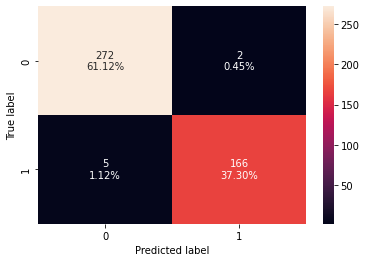

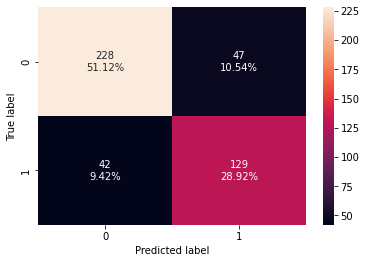

In [46]:
rf_classifier=RandomForestClassifier(random_state=1,class_weight='balanced')
rf_classifier.fit(X_train,y_train)

confusion_matrix_sklearn(rf_classifier,X_train,y_train)

confusion_matrix_sklearn(rf_classifier,X_val,y_val)

rf_classifier_pretune = get_metrics_score(rf_classifier, xtest=X_val, ytest=y_val)

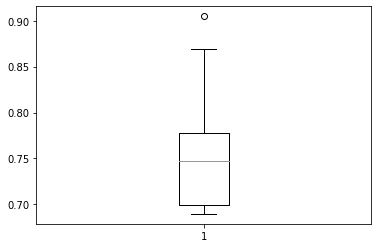

SCORE: Mean = 76.04%, Standard Deviation = 7.08%
95% Confidence Interval: 61.88% to 90.2%.


In [47]:
results = cross_val_score(rf_classifier,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## Our cross validation isn't great. We have a confidence interval between 61% and 90%. Let's tune the model.

In [48]:
%%time

rf_classifier_tuned = RandomForestClassifier(random_state=1,class_weight='balanced')

parameters = {
    "n_estimators": [500],
    "max_depth" : [7],
    "min_samples_leaf": [1],
    "max_features": [0.7],
    "max_samples": [0.3],
    "min_impurity_decrease": [0.001]
}

acc_scorer = scoring

grid_obj = RandomizedSearchCV(rf_classifier_tuned, param_distributions=parameters, n_iter=1, scoring=acc_scorer,cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

rf_classifier_tuned = grid_obj.best_estimator_

rf_classifier_tuned.fit(X_train, y_train)

CPU times: user 1.75 s, sys: 30.2 ms, total: 1.78 s
Wall time: 3.98 s


RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=0.7,
                       max_samples=0.3, min_impurity_decrease=0.001,
                       n_estimators=500, random_state=1)

In [49]:
grid_obj.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.001,
 'max_samples': 0.3,
 'max_features': 0.7,
 'max_depth': 7}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8921348314606742
Accuracy on val/test set :  0.820627802690583

Recall on training set :  0.7894736842105263
Recall on val/test set :  0.7368421052631579
Precision on training set :  0.9183673469387755
Precision on val/test set :  0.782608695652174
F1 on training set :  0.8490566037735849
F1 on val/test set :  0.7590361445783133

Specificity on training set :  0.9562043795620438
Specificity on val/test set :  0.8727272727272727
NPV on training set :  0.8791946308724832
NPV on val/test set :  0.8421052631578947
Inverted F1 on training set :  0.9160839160839161
Inverted F1 on val/test set :  0.8571428571428571

Harmonic Mean of F1 and Inverted F1 on train set :  0.8812976528629093
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.805111821086262


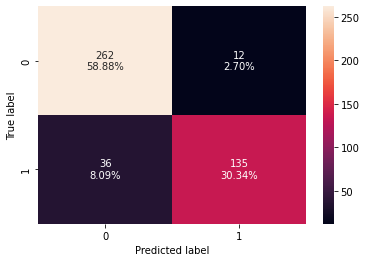

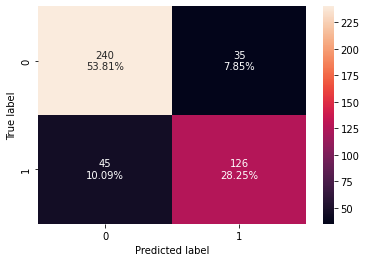

In [50]:
confusion_matrix_sklearn(rf_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(rf_classifier_tuned,X_val,y_val)

rf_classifier_posttune = get_metrics_score(rf_classifier_tuned, xtest=X_val, ytest=y_val)

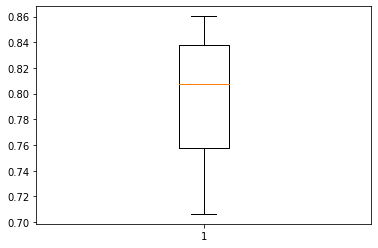

SCORE: Mean = 79.42%, Standard Deviation = 5.09%
95% Confidence Interval: 69.25% to 89.59%.


In [51]:
results = cross_val_score(rf_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## My best tuned random forest classifier has a mean HM F1/InvF1 score of 79% with a 5% standard deviation. Not much better, as it is unfortunately still very overfit.

## Next, let's do a logistic regression classifier.

These metrics are performed on the Validation set.

Accuracy on training set :  0.7932584269662921
Accuracy on val/test set :  0.7892376681614349

Recall on training set :  0.7660818713450293
Recall on val/test set :  0.7543859649122807
Precision on training set :  0.7158469945355191
Precision on val/test set :  0.712707182320442
F1 on training set :  0.7401129943502824
F1 on val/test set :  0.7329545454545454

Specificity on training set :  0.8102189781021898
Specificity on val/test set :  0.8109090909090909
NPV on training set :  0.8473282442748091
NPV on val/test set :  0.8415094339622642
Inverted F1 on training set :  0.8283582089552239
Inverted F1 on val/test set :  0.8259259259259258

Harmonic Mean of F1 and Inverted F1 on train set :  0.7817531786779925
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7766678366046599


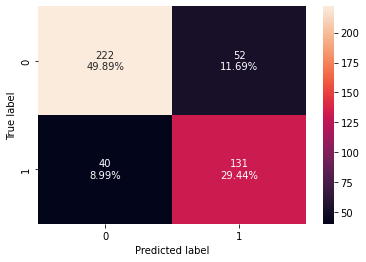

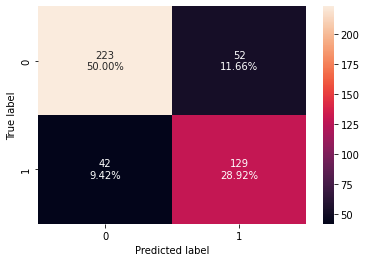

In [52]:
Log = LogisticRegression(random_state=1,max_iter=100,class_weight='balanced',
    penalty='l2',solver='liblinear') 

Log.fit(X_train, y_train)

confusion_matrix_sklearn(Log,X_train,y_train)

confusion_matrix_sklearn(Log,X_val,y_val)

Log_pretune = get_metrics_score(Log, xtest=X_val, ytest=y_val)

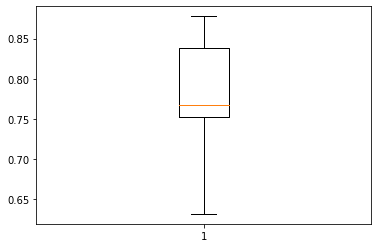

SCORE: Mean = 77.56%, Standard Deviation = 7.49%
95% Confidence Interval: 62.59% to 92.53%.


In [53]:
results = cross_val_score(Log,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

#### It is not overfit, so I will not be tuning the hyperparameters.
#### It is not as good as Random Forest, but also more generalized.

## Finally, let's try XGBoost.

These metrics are performed on the Validation set.

Accuracy on training set :  0.9797752808988764
Accuracy on val/test set :  0.7937219730941704

Recall on training set :  0.9532163742690059
Recall on val/test set :  0.7543859649122807
Precision on training set :  0.9939024390243902
Precision on val/test set :  0.7206703910614525
F1 on training set :  0.973134328358209
F1 on val/test set :  0.7371428571428571

Specificity on training set :  0.9963503649635036
Specificity on val/test set :  0.8181818181818182
NPV on training set :  0.9715302491103203
NPV on val/test set :  0.8426966292134831
Inverted F1 on training set :  0.9837837837837838
Inverted F1 on val/test set :  0.8302583025830259

Harmonic Mean of F1 and Inverted F1 on train set :  0.978430079155673
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7809347001372184


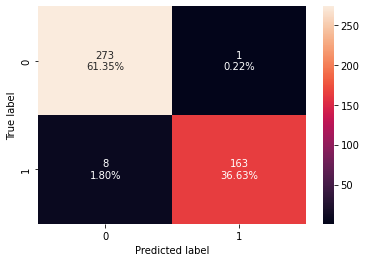

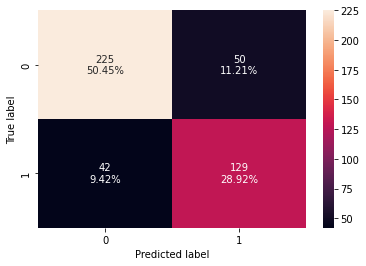

In [54]:
xgb_classifier=XGBClassifier(random_state=1)
xgb_classifier.fit(X_train,y_train)

confusion_matrix_sklearn(xgb_classifier,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier,X_val,y_val)

xgb_classifier_pretune = get_metrics_score(xgb_classifier, xtest=X_val, ytest=y_val)

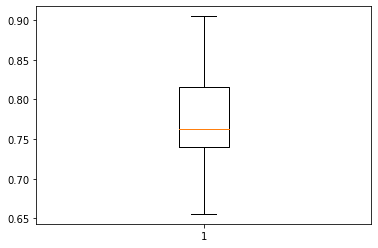

SCORE: Mean = 77.76%, Standard Deviation = 6.92%
95% Confidence Interval: 63.92% to 91.61%.


In [55]:
results = cross_val_score(xgb_classifier,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## Slightly better than our random forest's base model. Let's tune.

In [56]:
%%time
xgb_classifier_tuned = XGBClassifier(random_state=1)

parameters = {
    "n_estimators": [150,160,170,180],
    "scale_pos_weight":[2.0],
    "subsample":[0.9],
    "learning_rate":[0.3],
    "gamma":[10],
    "colsample_bytree":[1],
    "colsample_bylevel":[0.5],
    "colsample_bynode": [0.9],
}

acc_scorer = scoring

grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions=parameters, n_iter=4,scoring=acc_scorer,cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

xgb_classifier_tuned = grid_obj.best_estimator_

xgb_classifier_tuned.fit(X_train, y_train)

CPU times: user 3.61 s, sys: 79.6 ms, total: 3.69 s
Wall time: 4.12 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=0.9, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=160,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [57]:
grid_obj.best_params_

{'subsample': 0.9,
 'scale_pos_weight': 2.0,
 'n_estimators': 160,
 'learning_rate': 0.3,
 'gamma': 10,
 'colsample_bytree': 1,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 0.5}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8112359550561797
Accuracy on val/test set :  0.8161434977578476

Recall on training set :  0.8362573099415205
Recall on val/test set :  0.8128654970760234
Precision on training set :  0.7185929648241206
Precision on val/test set :  0.7354497354497355
F1 on training set :  0.7729729729729731
F1 on val/test set :  0.7722222222222224

Specificity on training set :  0.7956204379562044
Specificity on val/test set :  0.8181818181818182
NPV on training set :  0.8861788617886179
NPV on val/test set :  0.8754863813229572
Inverted F1 on training set :  0.8384615384615385
Inverted F1 on val/test set :  0.8458646616541353

Harmonic Mean of F1 and Inverted F1 on train set :  0.8043865307702232
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8073676330123655


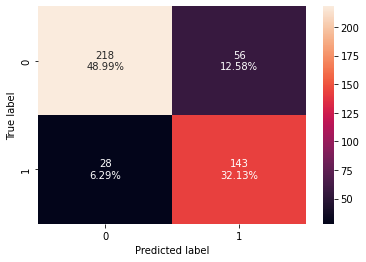

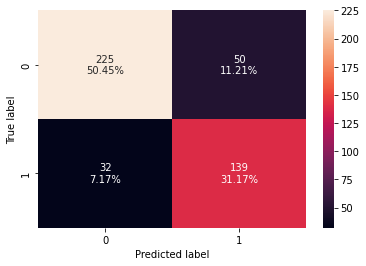

In [58]:
confusion_matrix_sklearn(xgb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned,X_val,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned, xtest=X_val, ytest=y_val)

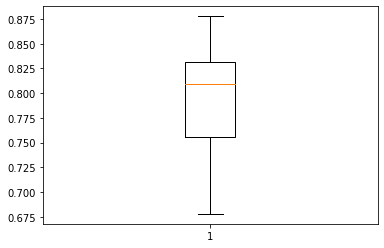

SCORE: Mean = 79.28%, Standard Deviation = 5.73%
95% Confidence Interval: 67.82% to 90.75%.


In [59]:
results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## This model, while performing slightly worse on the val set than our Random Forest, performs the most consistently and without overfitting.
## Let's check our gini importances before we move on.

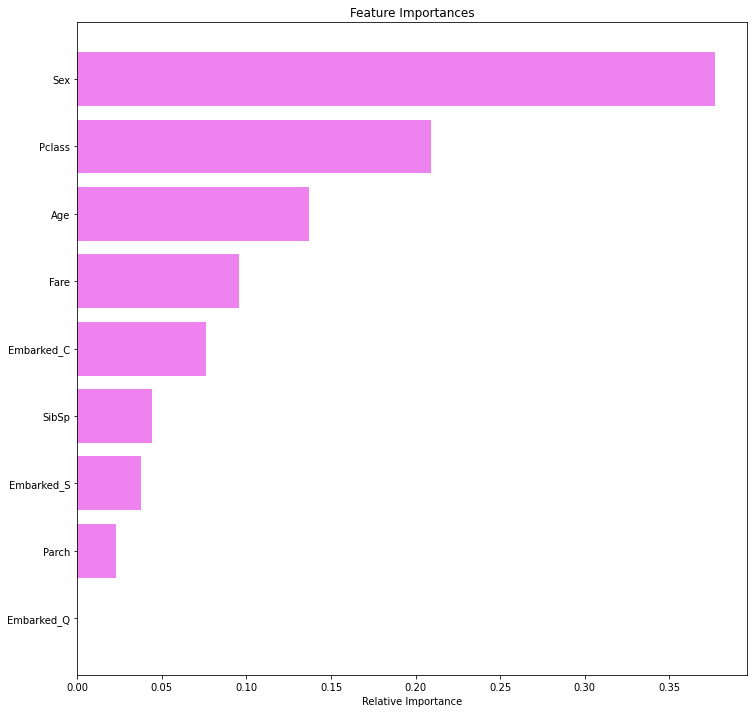

In [60]:
feature_names = X_train.columns
importances = xgb_classifier_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## The 5 highest relative importances belong to Sex, Pclass, Age, Fare, and Embarked_C (Cherbourg).

## Let's make a quick model using only these 5 features and see if it performs any better without all the noise from the less important features.

In [61]:
X_train_2 = X_train[['Sex', 'Pclass', 'Age', 'Fare', 'Embarked_C']]
X_val_2 = X_val[['Sex', 'Pclass', 'Age', 'Fare', 'Embarked_C']]
X_test_2 = X_test[['Sex', 'Pclass', 'Age', 'Fare', 'Embarked_C']]

In [62]:
X_train_2

,Sex,Pclass,Age,Fare,Embarked_C
0,-0.709492,0.865011,-0.305078,-0.520751,0
1,-0.709492,0.865011,-2.231124,0.256241,0
2,1.409460,-1.496521,-0.465582,1.550416,1
3,-0.709492,-1.496521,0.577693,0.033965,1
4,-0.709492,0.865011,-0.064322,-0.507103,0
...,...,...,...,...,...
440,1.409460,-1.496521,-0.064322,1.503782,1
441,-0.709492,-0.315755,0.577693,-0.453484,0
442,1.409460,0.865011,-0.305078,-0.503691,0
443,-0.709492,-0.315755,-2.070620,-0.151266,0


These metrics are performed on the Validation set.

Accuracy on training set :  0.9752808988764045
Accuracy on val/test set :  0.8116591928251121

Recall on training set :  0.9473684210526315
Recall on val/test set :  0.7777777777777778
Precision on training set :  0.9878048780487805
Precision on val/test set :  0.7430167597765364
F1 on training set :  0.9671641791044776
F1 on val/test set :  0.76

Specificity on training set :  0.9927007299270073
Specificity on val/test set :  0.8327272727272728
NPV on training set :  0.9679715302491103
NPV on val/test set :  0.8576779026217228
Inverted F1 on training set :  0.9801801801801802
Inverted F1 on val/test set :  0.845018450184502

Harmonic Mean of F1 and Inverted F1 on train set :  0.9736286803292273
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8002574949420637


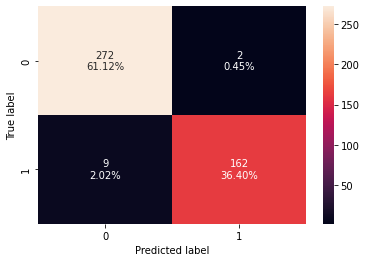

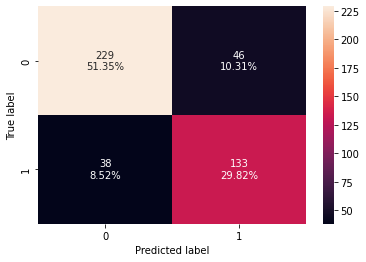

In [63]:
xgb_classifier=XGBClassifier(random_state=1)
xgb_classifier.fit(X_train_2,y_train)

confusion_matrix_sklearn(xgb_classifier,X_train_2,y_train)

confusion_matrix_sklearn(xgb_classifier,X_val_2,y_val)

xgb_classifier_pretune = get_metrics_score(xgb_classifier,X_train=X_train_2, xtest=X_val_2, ytest=y_val)

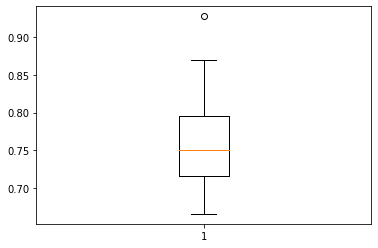

SCORE: Mean = 76.8%, Standard Deviation = 7.55%
95% Confidence Interval: 61.71% to 91.9%.


In [64]:
results = cross_val_score(xgb_classifier,X_train_2,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")


print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [65]:
grid_obj.best_params_ #80.2% - 64.46% to 90.01%.

{'subsample': 0.9,
 'scale_pos_weight': 2.0,
 'n_estimators': 160,
 'learning_rate': 0.3,
 'gamma': 10,
 'colsample_bytree': 1,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 0.5}

In [66]:
%%time
xgb_classifier_tuned_2 = XGBClassifier(random_state=1)

parameters = {
    "n_estimators": [100,150,160,170,180],
    "scale_pos_weight":[0.5,1.0,1.5,2.0,2.5],
    "subsample":[0.9,1.0],
    "learning_rate":[0.3,0.5,0.7,0.9,1.0],
    "gamma":[10],
    "colsample_bytree":[0.3,0.5,0.9,1.0],
    "colsample_bylevel":[0.3,0.5,0.9,1.0],
    "colsample_bynode": [0.3,0.5,0.9,1.0],
}

acc_scorer = scoring

grid_obj = RandomizedSearchCV(xgb_classifier_tuned_2, param_distributions=parameters, n_iter=35,scoring=acc_scorer,cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_2, y_train)

xgb_classifier_tuned_2 = grid_obj.best_estimator_

xgb_classifier_tuned_2.fit(X_train_2, y_train)

CPU times: user 5.39 s, sys: 95.7 ms, total: 5.48 s
Wall time: 26.1 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=0.9, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=170,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

These metrics are performed on the Validation set.

Accuracy on training set :  0.8134831460674158
Accuracy on val/test set :  0.8139013452914798

Recall on training set :  0.8070175438596491
Recall on val/test set :  0.783625730994152
Precision on training set :  0.7340425531914894
Precision on val/test set :  0.7444444444444445
F1 on training set :  0.7688022284122562
F1 on val/test set :  0.7635327635327634

Specificity on training set :  0.8175182481751825
Specificity on val/test set :  0.8327272727272728
NPV on training set :  0.8715953307392996
NPV on val/test set :  0.8609022556390977
Inverted F1 on training set :  0.8436911487758946
Inverted F1 on val/test set :  0.8465804066543439

Harmonic Mean of F1 and Inverted F1 on train set :  0.8045076580738351
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8029148378065453


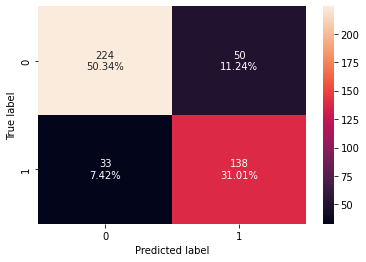

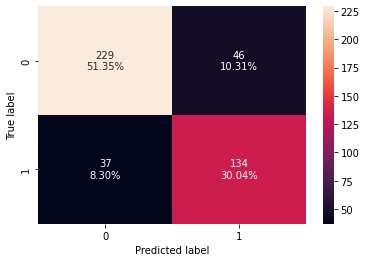

In [67]:
confusion_matrix_sklearn(xgb_classifier_tuned_2,X_train_2,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned_2,X_val_2,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned_2,X_train=X_train_2, xtest=X_val_2, ytest=y_val)

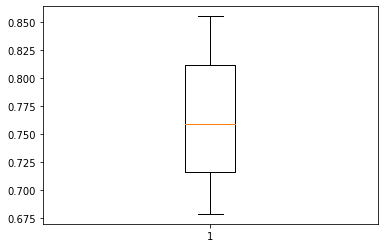

SCORE: Mean = 76.54%, Standard Deviation = 5.97%
95% Confidence Interval: 64.59% to 88.48%.


In [68]:
results = cross_val_score(xgb_classifier_tuned_2,X_train_2,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## Our 95% confidence intervals in our cross validations are very wide with this XGBoost model. I will write a new tuning code that will print out the best hyperparameters based on the minimum of the confidence interval.

In [69]:
%%time

dict_={}
count = 5

while count > 0:
    xgb_classifier_tuned_2 = XGBClassifier(random_state=1)

    parameters = {
        "n_estimators": [100,150,160,170,180],
        "scale_pos_weight":[0.5,1.0,1.5,2.0,2.5],
        "subsample":[0.9,1.0],
        "learning_rate":[0.3,0.5,0.7,0.9,1.0],
        "gamma":[10],
        "colsample_bytree":[0.3,0.5,0.9,1.0],
        "colsample_bylevel":[0.3,0.5,0.9,1.0],
        "colsample_bynode": [0.3,0.5,0.9,1.0],
    }

    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(xgb_classifier_tuned_2, param_distributions=parameters, n_iter=10,scoring=acc_scorer,cv=5, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train_2, y_train)

    xgb_classifier_tuned_2 = grid_obj.best_estimator_

    xgb_classifier_tuned_2.fit(X_train_2, y_train)

    results = cross_val_score(xgb_classifier_tuned_2,X_train_2,y_train,cv=kFold,scoring=scoring,n_jobs=-1)
    low = round(100*(results.mean() - 2*(results.std())),2)
    dict_.update({low:grid_obj.best_params_})
    
    count = count - 1
print(f"The highest confidence interval minimum is {max(dict_)}%.")
dict_[max(dict_)]

The highest confidence interval minimum is 62.03%.
CPU times: user 18.4 s, sys: 272 ms, total: 18.7 s
Wall time: 48.8 s


{'subsample': 1.0,
 'scale_pos_weight': 2.0,
 'n_estimators': 150,
 'learning_rate': 0.9,
 'gamma': 10,
 'colsample_bytree': 0.5,
 'colsample_bynode': 0.3,
 'colsample_bylevel': 0.5}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8269662921348314
Accuracy on val/test set :  0.8004484304932735

Recall on training set :  0.8011695906432749
Recall on val/test set :  0.7309941520467836
Precision on training set :  0.7611111111111111
Precision on val/test set :  0.7440476190476191
F1 on training set :  0.7806267806267805
F1 on val/test set :  0.737463126843658

Specificity on training set :  0.843065693430657
Specificity on val/test set :  0.8436363636363636
NPV on training set :  0.8716981132075472
NPV on val/test set :  0.8345323741007195
Inverted F1 on training set :  0.8571428571428572
Inverted F1 on val/test set :  0.8390596745027125

Harmonic Mean of F1 and Inverted F1 on train set :  0.8170974155069581
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.784987785319375


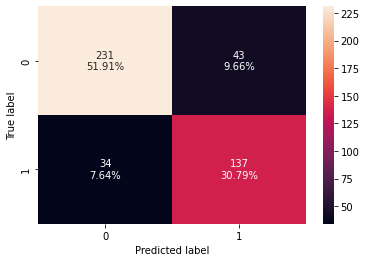

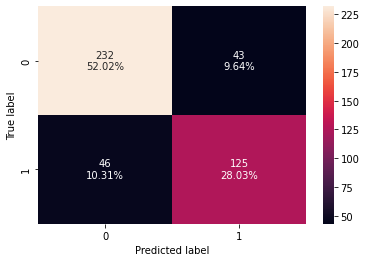

In [70]:
xgb_classifier=XGBClassifier(random_state=1,
                            subsample= .9,
                             scale_pos_weight= 1.5,
                             n_estimators= 160,
                             learning_rate= 0.5,
                             gamma= 10,
                             colsample_bytree= 0.9,
                             colsample_bynode= 0.5,
                             colsample_bylevel= 0.9)
xgb_classifier.fit(X_train_2,y_train)

confusion_matrix_sklearn(xgb_classifier,X_train_2,y_train)

confusion_matrix_sklearn(xgb_classifier,X_val_2,y_val)

xgb_classifier_pretune = get_metrics_score(xgb_classifier,X_train=X_train_2, xtest=X_val_2, ytest=y_val)

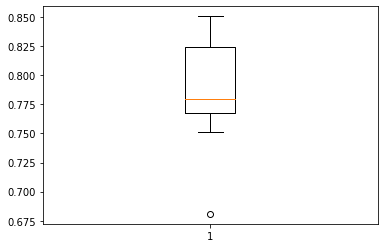

SCORE: Mean = 78.61%, Standard Deviation = 4.81%
95% Confidence Interval: 68.99% to 88.23%.


In [71]:
results = cross_val_score(xgb_classifier,X_train_2,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")


print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

#### While the confidence interval is extremely tight, we did not end up improving upon the original data.
## Let's try again on the XGBoost original data.

In [72]:
%%time

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

dict_={}
count = 1

while count > 0:

    xgb_classifier_tuned = XGBClassifier(random_state=1)

    parameters = {
        "n_estimators": [360],
        "scale_pos_weight":[1.4],
        "subsample":[0.9],
        "learning_rate":[0.6],
        "gamma":[10],
        "colsample_bytree":[0.7],
        "colsample_bylevel":[0.5],
        "colsample_bynode": [0.9],
    }

    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions=parameters, n_iter=1,scoring=acc_scorer,cv=5, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    xgb_classifier_tuned = grid_obj.best_estimator_

    xgb_classifier_tuned.fit(X_train, y_train)
    
    results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)
    low = round(100*(results.mean() - 2*(results.std())),2)
    dict_.update({low:grid_obj.best_params_})
    
    count = count - 1
    
print(f"The highest confidence interval minimum is {max(dict_)}%.")
dict_[max(dict_)]

The highest confidence interval minimum is 70.06%.
CPU times: user 7.55 s, sys: 124 ms, total: 7.67 s
Wall time: 7.83 s


{'subsample': 0.9,
 'scale_pos_weight': 1.4,
 'n_estimators': 360,
 'learning_rate': 0.6,
 'gamma': 10,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 0.5}

    The highest confidence interval minimum is 70.06%.
    CPU times: user 20min 38s, sys: 16.6 s, total: 20min 54s
    Wall time: 54min 40s
    {'subsample': 0.9,
    'scale_pos_weight': 1.4,
    'n_estimators': 360,
    'learning_rate': 0.6,
    'gamma': 10,
    'colsample_bytree': 0.7,
    'colsample_bynode': 0.9,
    'colsample_bylevel': 0.5}

    SCORE: Mean = 78.03%, Standard Deviation = 3.98%
    95% Confidence Interval: 70.06% to 85.99%.

## After a few runs of RandomizedSearch, I found this confidence interval. I will be looping through the hyperparameter tuning again to search for an even better one.

In [73]:
%%time

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

low = 0

while low < 70.07:

    xgb_classifier_tuned = XGBClassifier(random_state=1)

    parameters = {
        "n_estimators": [320],
        "scale_pos_weight":[1.8],
        "subsample":[0.9],
        "learning_rate":[0.3],
        "gamma":[10],
        "colsample_bytree":[1.0],
        "colsample_bylevel":[0.5],
        "colsample_bynode": [0.9],
    }

    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions=parameters, n_iter=1,scoring=acc_scorer,cv=5, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    xgb_classifier_tuned = grid_obj.best_estimator_

    xgb_classifier_tuned.fit(X_train, y_train)
    
    results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)
    low = round(100*(results.mean() - 2*(results.std())),2)
    
print(f"The highest confidence interval minimum is {low}%.")
grid_obj.best_params_

The highest confidence interval minimum is 71.0%.
CPU times: user 6.87 s, sys: 121 ms, total: 7 s
Wall time: 6.87 s


{'subsample': 0.9,
 'scale_pos_weight': 1.8,
 'n_estimators': 320,
 'learning_rate': 0.3,
 'gamma': 10,
 'colsample_bytree': 1.0,
 'colsample_bynode': 0.9,
 'colsample_bylevel': 0.5}

    The highest confidence interval minimum is 71.0%.
    CPU times: user 2h 3min 29s, sys: 1min 41s, total: 2h 5min 11s
    Wall time: 6h 26min 22s
    
    {'subsample': 0.9,
     'scale_pos_weight': 1.8,
     'n_estimators': 320,
     'learning_rate': 0.3,
     'gamma': 10,
     'colsample_bytree': 1.0,
     'colsample_bynode': 0.9,
     'colsample_bylevel': 0.5}
     
    SCORE: Mean = 78.35%, Standard Deviation = 3.68%
    95% Confidence Interval: 71.0% to 85.7%.

These metrics are performed on the Validation set.

Accuracy on training set :  0.8337078651685393
Accuracy on val/test set :  0.804932735426009

Recall on training set :  0.8187134502923976
Recall on val/test set :  0.8245614035087719
Precision on training set :  0.7650273224043715
Precision on val/test set :  0.7121212121212122
F1 on training set :  0.7909604519774012
F1 on val/test set :  0.7642276422764227

Specificity on training set :  0.843065693430657
Specificity on val/test set :  0.7927272727272727
NPV on training set :  0.8816793893129771
NPV on val/test set :  0.8790322580645161
Inverted F1 on training set :  0.8619402985074627
Inverted F1 on val/test set :  0.8336520076481835

Harmonic Mean of F1 and Inverted F1 on train set :  0.8249263458619766
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7974316567759508


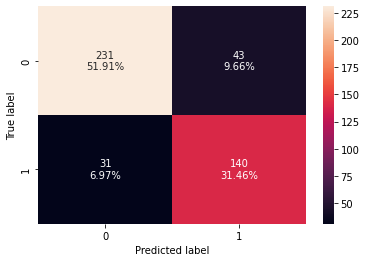

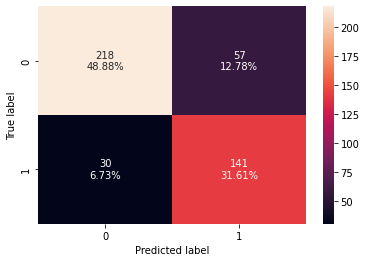

In [74]:
confusion_matrix_sklearn(xgb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned,X_val,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned, xtest=X_val, ytest=y_val)

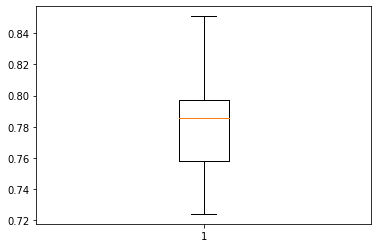

SCORE: Mean = 78.35%, Standard Deviation = 3.68%
95% Confidence Interval: 71.0% to 85.7%.


In [75]:
results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## This is a very tight confidence interval. The model is quite good at generalizing.

## I'm going to try one more method: an average of the SCORE mean and 100 minus the standard deviation (100-SD because as SD goes down, 100-SD goes up, increasing the average).
    Example: (78.35 + (100-3.68)) / 2 = 87.335, using the 95% confidence interval above.

    The highest confidence interval average is 87.03999999999999%. Iteration: 223
    CPU times: user 29min 22s, sys: 30.5 s, total: 29min 52s
    Wall time: 36min 35s
    {'subsample': 1.0,
    'scale_pos_weight': 1.8000000000000003,
    'n_estimators': 370,
    'learning_rate': 0.28,
    'gamma': 10,
    'colsample_bytree': 0.9,
    'colsample_bynode': 0.5,
    'colsample_bylevel': 0.9}
    
    SCORE: Mean = 79.14%, Standard Deviation = 4.48%
    95% Confidence Interval: 70.19% to 88.09%.
    
    SCORE: Mean = 78.36%, Standard Deviation = 4.86%
    95% Confidence Interval: 68.64% to 88.08%.

In [76]:
%%time

low = 0
count = 0

while low < 87:
    count=count+1

    xgb_classifier_tuned = XGBClassifier(random_state=1)

    parameters = {
        "n_estimators": [370],
        "scale_pos_weight": [1.8],
        "subsample": [1.0],
        "learning_rate": [0.28],
        "gamma": [10],
        "colsample_bytree": [0.9],
        "colsample_bylevel": [0.9],
        "colsample_bynode": [0.5],
    }

    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions=parameters, n_iter=1,scoring=acc_scorer,cv=2, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    xgb_classifier_tuned = grid_obj.best_estimator_
    
    xgb_classifier_tuned.fit(X_train, y_train)
    
    results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)
    results_val = cross_val_score(xgb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)
    low = (((1*round(results.mean()*100,2) + (100-round(results.std()*100,2)))/2) + ((1*round(results_val.mean()*100,2) + (100-round(results_val.std()*100,2)))/2)) / 2
    
print(f"The highest confidence interval average is {low}%. Iteration: {count}")
grid_obj.best_params_

The highest confidence interval average is 87.03999999999999%. Iteration: 1
CPU times: user 7.97 s, sys: 156 ms, total: 8.13 s
Wall time: 10.8 s


{'subsample': 1.0,
 'scale_pos_weight': 1.8,
 'n_estimators': 370,
 'learning_rate': 0.28,
 'gamma': 10,
 'colsample_bytree': 0.9,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 0.9}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8314606741573034
Accuracy on val/test set :  0.8071748878923767

Recall on training set :  0.8654970760233918
Recall on val/test set :  0.8070175438596491
Precision on training set :  0.74
Precision on val/test set :  0.7225130890052356
F1 on training set :  0.797843665768194
F1 on val/test set :  0.7624309392265193

Specificity on training set :  0.8102189781021898
Specificity on val/test set :  0.8072727272727273
NPV on training set :  0.9061224489795918
NPV on val/test set :  0.8705882352941177
Inverted F1 on training set :  0.8554913294797688
Inverted F1 on val/test set :  0.8377358490566038

Harmonic Mean of F1 and Inverted F1 on train set :  0.8256624825662482
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.798311444652908


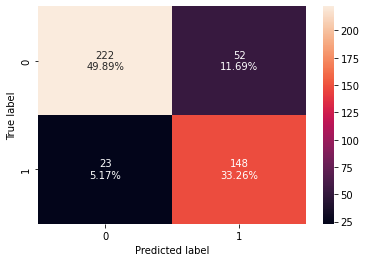

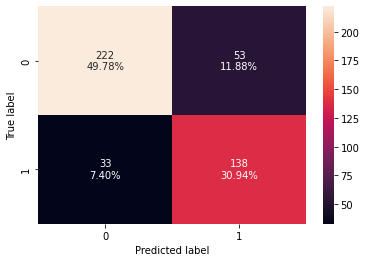

In [77]:
confusion_matrix_sklearn(xgb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned,X_val,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned, xtest=X_val, ytest=y_val)

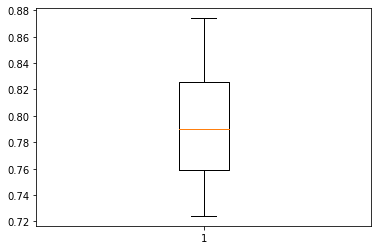

SCORE: Mean = 79.14%, Standard Deviation = 4.48%
95% Confidence Interval: 70.19% to 88.09%.


In [78]:
results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

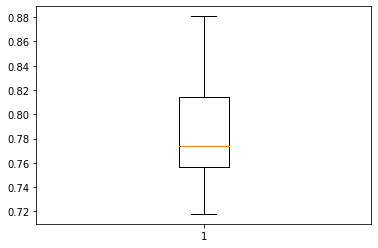

SCORE: Mean = 78.36%, Standard Deviation = 4.86%
95% Confidence Interval: 68.64% to 88.08%.


In [79]:
results = cross_val_score(xgb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [80]:
FinalModel = pd.DataFrame([test,xgb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})

In [81]:
FinalModel.to_csv('file.csv',index=False)

#### This prediction ended up scoring 73% accuracy in the competition, netting me around 12,000th place.
#### I've seen discussion of people getting up to 80% with a blend of Random Forest, SVM, and XGBoost, but I do not know how to implement SVM yet!

## Let's try again, but with a larger mix of models, and scoring by accuracy instead.

In [82]:
scoring = make_scorer(metrics.accuracy_score)

# Decision Tree Classifier

These metrics are performed on the Validation set.

Accuracy on training set :  0.9842696629213483
Accuracy on val/test set :  0.7713004484304933

Recall on training set :  0.9824561403508771
Recall on val/test set :  0.7076023391812866
Precision on training set :  0.9767441860465116
Precision on val/test set :  0.6994219653179191
F1 on training set :  0.9795918367346939
F1 on val/test set :  0.7034883720930233

Specificity on training set :  0.9854014598540146
Specificity on val/test set :  0.8109090909090909
NPV on training set :  0.989010989010989
NPV on val/test set :  0.8168498168498168
Inverted F1 on training set :  0.9872029250457038
Inverted F1 on val/test set :  0.8138686131386862

Harmonic Mean of F1 and Inverted F1 on train set :  0.9833826542226268
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7546636834009229


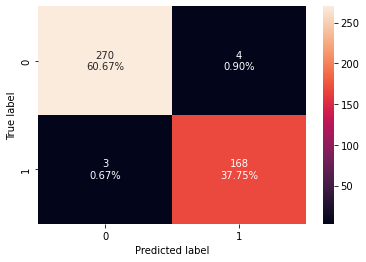

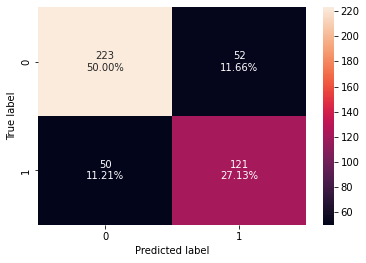

In [83]:
dtree=DecisionTreeClassifier(random_state=1,class_weight='balanced')
dtree.fit(X_train,y_train)

confusion_matrix_sklearn(dtree,X_train,y_train)

confusion_matrix_sklearn(dtree,X_val,y_val)

dtree_pretune = get_metrics_score(dtree, xtest=X_val, ytest=y_val)

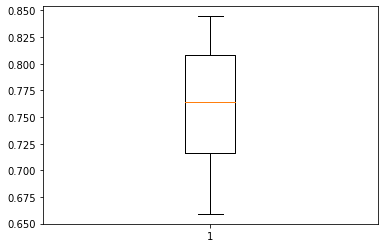

SCORE: Mean = 75.49%, Standard Deviation = 6.15%
95% Confidence Interval: 63.19% to 87.79%.


In [84]:
results = cross_val_score(dtree,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

# Let's tune the hyperparameters:

    The highest confidence interval average is 87.78750000000001%. Iteration: 37
    CPU times: user 4.57 s, sys: 160 ms, total: 4.73 s
    Wall time: 5.64 s
    {'min_samples_split': 10,
    'min_samples_leaf': 3,
    'min_impurity_decrease': 1e-14,
    'max_leaf_nodes': 20,
    'max_depth': 22}

    Accuracy on training set :  0.8764044943820225
    Accuracy on val/test set :  0.804932735426009

    SCORE: Mean = 78.43%, Standard Deviation = 4.83%
    95% Confidence Interval: 68.77% to 88.09%.

    SCORE: Mean = 83.65%, Standard Deviation = 6.1%
    95% Confidence Interval: 71.45% to 95.85%.

In [85]:
%%time

low = 0
count = 0

while low < 87.7:
    count=count+1

    dt_estimator = DecisionTreeClassifier(random_state=1,class_weight='balanced')

    parameters = {'max_depth': [22], 
                  'min_samples_leaf': [3],
                  'max_leaf_nodes' : [20],
                  'min_impurity_decrease': [0.00000000000001],
                  'min_samples_split' : [10]
                 }


    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(dt_estimator, param_distributions=parameters,n_iter=1, scoring=acc_scorer,cv=2,n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    dt_estimator = grid_obj.best_estimator_

    dt_estimator.fit(X_train, y_train)
    results = cross_val_score(dt_estimator,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)
    results_val = cross_val_score(dt_estimator,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)
    low = (((round(results.mean()*100,2) + ((100-round(results.std()*100,2))))/2) + ((round(results_val.mean()*100,2) + ((100-round(results_val.std()*100,2))))/2)) / 2

print(f"The highest confidence interval average is {low}%. Iteration: {count}")
grid_obj.best_params_

The highest confidence interval average is 87.78750000000001%. Iteration: 1
CPU times: user 116 ms, sys: 5.54 ms, total: 122 ms
Wall time: 160 ms


{'min_samples_split': 10,
 'min_samples_leaf': 3,
 'min_impurity_decrease': 1e-14,
 'max_leaf_nodes': 20,
 'max_depth': 22}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8764044943820225
Accuracy on val/test set :  0.804932735426009

Recall on training set :  0.8538011695906432
Recall on val/test set :  0.7660818713450293
Precision on training set :  0.8295454545454546
Precision on val/test set :  0.7359550561797753
F1 on training set :  0.8414985590778099
F1 on val/test set :  0.7507163323782237

Specificity on training set :  0.8905109489051095
Specificity on val/test set :  0.8290909090909091
NPV on training set :  0.9070631970260223
NPV on val/test set :  0.8507462686567164
Inverted F1 on training set :  0.8987108655616943
Inverted F1 on val/test set :  0.8397790055248618

Harmonic Mean of F1 and Inverted F1 on train set :  0.8691642370048676
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7927540559370958


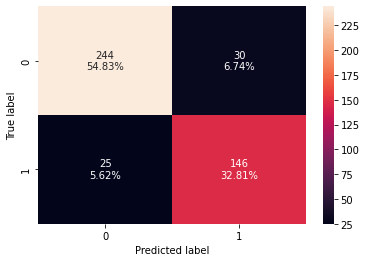

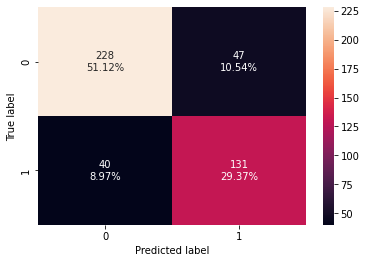

In [86]:
confusion_matrix_sklearn(dt_estimator,X_train,y_train)

confusion_matrix_sklearn(dt_estimator,X_val,y_val)

dtree_posttune = get_metrics_score(dt_estimator, xtest=X_val, ytest=y_val)

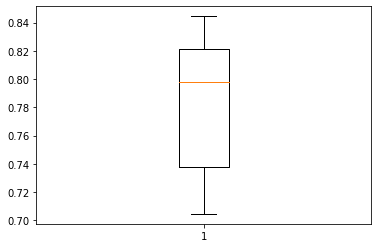

SCORE: Mean = 78.43%, Standard Deviation = 4.83%
95% Confidence Interval: 68.77% to 88.09%.


In [87]:
results = cross_val_score(dt_estimator,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

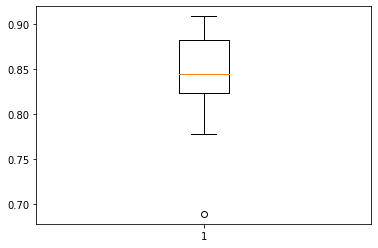

SCORE: Mean = 83.65%, Standard Deviation = 6.1%
95% Confidence Interval: 71.45% to 95.85%.


In [88]:
results = cross_val_score(dt_estimator,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [89]:
FinalModel = pd.DataFrame([test,dt_estimator.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('file.csv',index=False)

## Submitting this model resulted in a lower ranking, 0.71% accuracy. This is due to how overfit the dtree was in this case.

## Let's try a Gradient Boost next.

These metrics are performed on the Validation set.

Accuracy on training set :  0.9258426966292135
Accuracy on val/test set :  0.8026905829596412

Recall on training set :  0.847953216374269
Recall on val/test set :  0.7017543859649122
Precision on training set :  0.9539473684210527
Precision on val/test set :  0.7643312101910829
F1 on training set :  0.8978328173374612
F1 on val/test set :  0.7317073170731707

Specificity on training set :  0.9744525547445255
Specificity on val/test set :  0.8654545454545455
NPV on training set :  0.9112627986348123
NPV on val/test set :  0.8235294117647058
Inverted F1 on training set :  0.9417989417989417
Inverted F1 on val/test set :  0.8439716312056739

Harmonic Mean of F1 and Inverted F1 on train set :  0.9192904972218264
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7838401580854101


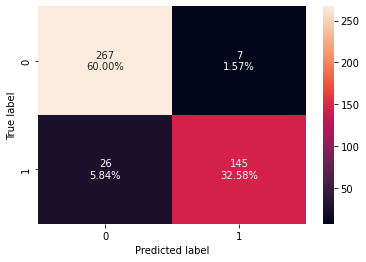

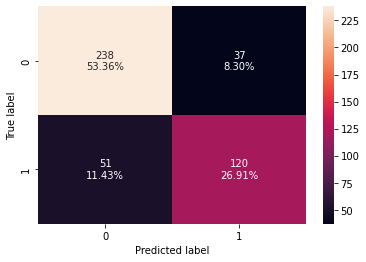

In [90]:
gb_classifier=GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

confusion_matrix_sklearn(gb_classifier,X_train,y_train)

confusion_matrix_sklearn(gb_classifier,X_val,y_val)

gb_classifier_pretune = get_metrics_score(gb_classifier, xtest=X_val, ytest=y_val)

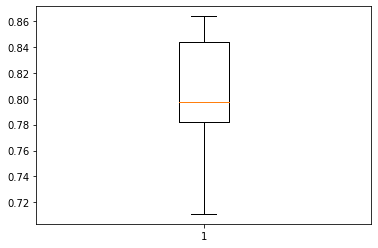

SCORE: Mean = 80.48%, Standard Deviation = 4.68%
95% Confidence Interval: 71.11% to 89.85%.


In [91]:
results = cross_val_score(gb_classifier,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## This is easily the best model I've seen yet. Let's see if we can get any improvement by tuning the hyperparameters.

    The highest confidence interval average is 87.515%. Iteration: 43
    CPU times: user 20.7 s, sys: 222 ms, total: 20.9 s
    Wall time: 1min 17s
    {'subsample': 0.30000000000000004,
    'n_estimators': 40,
    'min_samples_split': 0.1,
    'min_samples_leaf': 0.01,
    'max_features': None,
    'learning_rate': 0.2}

    Accuracy on training set :  0.8471910112359551
    Accuracy on val/test set :  0.827354260089686

    SCORE: Mean = 80.91%, Standard Deviation = 6.63%
    95% Confidence Interval: 67.65% to 94.17%.

    SCORE: Mean = 81.19%, Standard Deviation = 5.41%
    95% Confidence Interval: 70.36% to 92.01%.

In [92]:
%%time

low = 0
count = 0

while low < 70.48:
    count=count+1
    
    gb_classifier_tuned = GradientBoostingClassifier(random_state=1)

    parameters = {
        "n_estimators": [40],
        "subsample": [0.3],
        "max_features": [None],
        "min_samples_leaf": [0.01],
        "min_samples_split": [0.1],
        "learning_rate" : [0.2]
    }

    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(gb_classifier_tuned, param_distributions=parameters, n_iter=1, scoring=acc_scorer,cv=2, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    gb_classifier_tuned = grid_obj.best_estimator_

    gb_classifier_tuned.fit(X_train, y_train)

    results = cross_val_score(gb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)
    results_val = cross_val_score(gb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)
    low = (((1*round(results.mean()*100,2) + (100-round(results.std()*100,2)))/2) + ((1*round(results_val.mean()*100,2) + (100-round(results_val.std()*100,2)))/2)) / 2
    
print(f"The highest confidence interval average is {low}%. Iteration: {count}")
grid_obj.best_params_

The highest confidence interval average is 87.515%. Iteration: 1
CPU times: user 206 ms, sys: 6.15 ms, total: 213 ms
Wall time: 452 ms


{'subsample': 0.3,
 'n_estimators': 40,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.01,
 'max_features': None,
 'learning_rate': 0.2}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8471910112359551
Accuracy on val/test set :  0.827354260089686

Recall on training set :  0.7543859649122807
Recall on val/test set :  0.7309941520467836
Precision on training set :  0.832258064516129
Precision on val/test set :  0.8012820512820513
F1 on training set :  0.7914110429447853
F1 on val/test set :  0.7645259938837919

Specificity on training set :  0.9051094890510949
Specificity on val/test set :  0.8872727272727273
NPV on training set :  0.8551724137931035
NPV on val/test set :  0.8413793103448276
Inverted F1 on training set :  0.8794326241134751
Inverted F1 on val/test set :  0.863716814159292

Harmonic Mean of F1 and Inverted F1 on train set :  0.8331033046014427
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8111001043792756


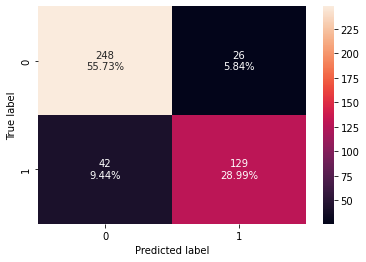

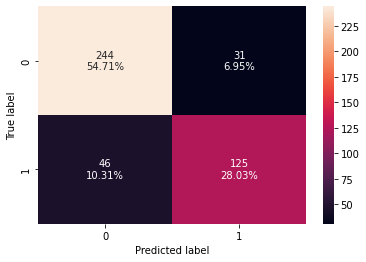

In [93]:
confusion_matrix_sklearn(gb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(gb_classifier_tuned,X_val,y_val)

gb_classifier_posttune = get_metrics_score(gb_classifier_tuned, xtest=X_val, ytest=y_val)

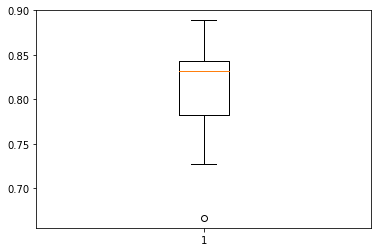

SCORE: Mean = 80.91%, Standard Deviation = 6.63%
95% Confidence Interval: 67.65% to 94.17%.


In [94]:
results = cross_val_score(gb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

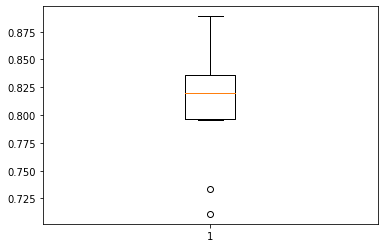

SCORE: Mean = 81.19%, Standard Deviation = 5.41%
95% Confidence Interval: 70.36% to 92.01%.


In [95]:
results = cross_val_score(gb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

## Let's try a different angle; many of these Gradient Boost tunings end up overfit or with high quantities of outliers.

#### I will be searching by train and val accuracy at once, while optimizing for a lower gap between the two accuracies.

    The highest val/train/diff accuracy is 0.9265944475235551%. Iteration: 436
    CPU times: user 2min 2s, sys: 239 ms, total: 2min 2s
    Wall time: 2min 55s
    {'subsample': 0.3,
    'n_estimators': 80,
    'min_samples_split': 0.2,
    'min_samples_leaf': 0.01,
    'max_features': None,
    'learning_rate': 0.1}

    Accuracy on training set :  0.8471910112359551
    Accuracy on val/test set :  0.8318385650224215

    SCORE: Mean = 78.45%, Standard Deviation = 7.14%
    95% Confidence Interval: 64.17% to 92.73%.

    SCORE: Mean = 80.08%, Standard Deviation = 4.83%
    95% Confidence Interval: 70.42% to 89.73%.

In [96]:
%%time

def accuracy_train_val_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    y_pred_val = estimator.predict(X_val)
    train_acc = metrics.accuracy_score(y_true,y_pred)
    val_acc = metrics.accuracy_score(y_val,y_pred_val)
    avg_acc = (train_acc + val_acc)/2
    acc_diff = 1+(0-np.abs(train_acc-val_acc))
    
    return ((2*avg_acc)+(3*acc_diff))/5

low = 0
count = 0

while low < 0.926594:
    count=count+1

    gb_classifier_tuned = GradientBoostingClassifier(random_state=1)

    parameters = {
        "n_estimators": [80],
        "subsample": [0.3],
        "max_features":[None],
        "min_samples_leaf": [0.01], 
        "min_samples_split": [0.2], 
        "learning_rate" : [0.1]
    }

    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(gb_classifier_tuned, param_distributions=parameters, n_iter=1, scoring=acc_scorer,cv=2, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    gb_classifier_tuned = grid_obj.best_estimator_

    gb_classifier_tuned.fit(X_train, y_train)
    
    low = accuracy_train_val_scorer(gb_classifier_tuned,X_train,y_train)
    
print(f"The highest val/train/diff accuracy is {low}%. Iteration: {count}")
grid_obj.best_params_

The highest val/train/diff accuracy is 0.9265944475235551%. Iteration: 1
CPU times: user 129 ms, sys: 913 µs, total: 130 ms
Wall time: 181 ms


{'subsample': 0.3,
 'n_estimators': 80,
 'min_samples_split': 0.2,
 'min_samples_leaf': 0.01,
 'max_features': None,
 'learning_rate': 0.1}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8471910112359551
Accuracy on val/test set :  0.8318385650224215

Recall on training set :  0.7485380116959064
Recall on val/test set :  0.7719298245614035
Precision on training set :  0.8366013071895425
Precision on val/test set :  0.7857142857142857
F1 on training set :  0.7901234567901233
F1 on val/test set :  0.7787610619469025

Specificity on training set :  0.9087591240875912
Specificity on val/test set :  0.8690909090909091
NPV on training set :  0.8527397260273972
NPV on val/test set :  0.8597122302158273
Inverted F1 on training set :  0.8798586572438162
Inverted F1 on val/test set :  0.864376130198915

Harmonic Mean of F1 and Inverted F1 on train set :  0.8325801311355502
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.819338125012174


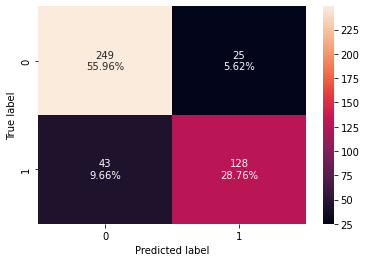

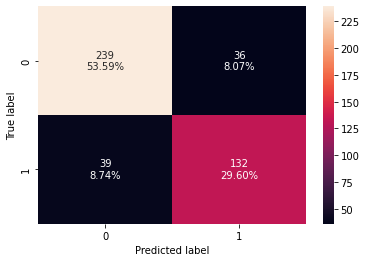

In [97]:
confusion_matrix_sklearn(gb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(gb_classifier_tuned,X_val,y_val)

gb_classifier_posttune = get_metrics_score(gb_classifier_tuned, xtest=X_val, ytest=y_val)

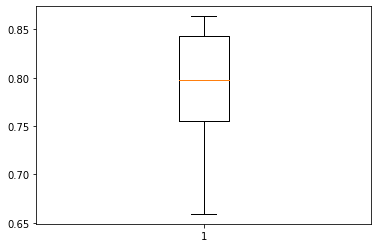

SCORE: Mean = 78.45%, Standard Deviation = 7.14%
95% Confidence Interval: 64.17% to 92.73%.


In [98]:
results = cross_val_score(gb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

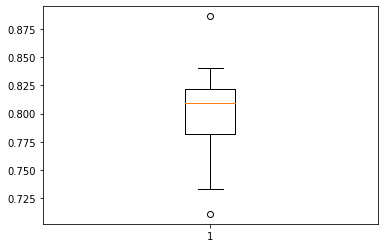

SCORE: Mean = 80.08%, Standard Deviation = 4.83%
95% Confidence Interval: 70.42% to 89.73%.


In [99]:
results = cross_val_score(gb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [100]:
FinalModel = pd.DataFrame([test,gb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('file.csv',index=False)

## Woo baby! Score: 0.77272 8000th place!

#### For reference, to break into the top 2000, I only need 0.01 more accuracy...

## I have a good feeling about XGBoost. I will try one more time, using the same search method I implemented for my good GradientBoost model.

    If that doesn't work out, I still have one more trick up my sleeve...

These metrics are performed on the Validation set.

Accuracy on training set :  0.9797752808988764
Accuracy on val/test set :  0.7937219730941704

Recall on training set :  0.9532163742690059
Recall on val/test set :  0.7543859649122807
Precision on training set :  0.9939024390243902
Precision on val/test set :  0.7206703910614525
F1 on training set :  0.973134328358209
F1 on val/test set :  0.7371428571428571

Specificity on training set :  0.9963503649635036
Specificity on val/test set :  0.8181818181818182
NPV on training set :  0.9715302491103203
NPV on val/test set :  0.8426966292134831
Inverted F1 on training set :  0.9837837837837838
Inverted F1 on val/test set :  0.8302583025830259

Harmonic Mean of F1 and Inverted F1 on train set :  0.978430079155673
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7809347001372184


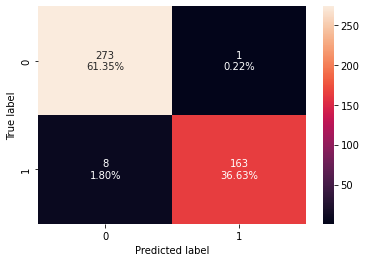

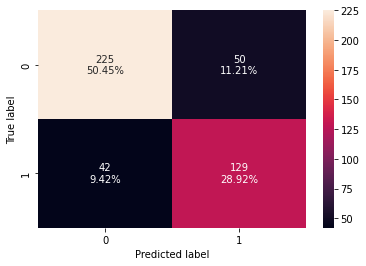

In [101]:
xgb_classifier=XGBClassifier(random_state=1)
xgb_classifier.fit(X_train,y_train)

confusion_matrix_sklearn(xgb_classifier,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier,X_val,y_val)

xgb_classifier_pretune = get_metrics_score(xgb_classifier, xtest=X_val, ytest=y_val)

## Yet again, XGBoost Hyperparameter Tuning...

    The highest val/train/diff accuracy is 0.9342389277976519%. Iteration: 732
    CPU times: user 57min 41s, sys: 39 s, total: 58min 20s
    Wall time: 20min 55s
    {'subsample': 0.8999999999999999,
    'scale_pos_weight': 0.8000000000000002,
    'n_estimators': 320,
    'learning_rate': 0.1,
    'gamma': 6,
    'colsample_bytree': 0.8,
    'colsample_bynode': 0.5,
    'colsample_bylevel': 0.6}

    Accuracy on training set :  0.8382022471910112
    Accuracy on val/test set :  0.8408071748878924

    SCORE: Mean = 79.34%, Standard Deviation = 4.03%
    95% Confidence Interval: 71.27% to 87.41%.

    SCORE: Mean = 82.08%, Standard Deviation = 4.3%
    95% Confidence Interval: 73.47% to 90.68%.

In [102]:
%%time

def accuracy_train_val_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    y_pred_val = estimator.predict(X_val)
    train_acc = metrics.accuracy_score(y_true,y_pred)
    val_acc = metrics.accuracy_score(y_val,y_pred_val)
    avg_acc = (train_acc + val_acc)/2
    acc_diff = 1+(0-np.abs(train_acc-val_acc))

    return ((2*avg_acc)+(3*acc_diff))/5

low = 0
count = 0

while low < 0.93422: 
    count=count+1
    xgb_classifier_tuned = XGBClassifier(random_state=1)

    parameters = {
        "n_estimators": [320],
        "scale_pos_weight": [0.8],
        "subsample": [0.9],
        "learning_rate": [0.1],
        "gamma": [6], 
        "colsample_bytree": [0.8],
        "colsample_bylevel": [0.6],
        "colsample_bynode": [0.5],
    }
    acc_scorer = scoring

    grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions=parameters,n_iter=1,scoring=acc_scorer,cv=2, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)

    xgb_classifier_tuned = grid_obj.best_estimator_

    xgb_classifier_tuned.fit(X_train, y_train)
    
    low = accuracy_train_val_scorer(xgb_classifier_tuned,X_train,y_train)

print(f"The highest val/train/diff accuracy is {low}%. Iteration: {count}")
grid_obj.best_params_

The highest val/train/diff accuracy is 0.9342389277976519%. Iteration: 1
CPU times: user 6.57 s, sys: 101 ms, total: 6.67 s
Wall time: 2.4 s


{'subsample': 0.9,
 'scale_pos_weight': 0.8,
 'n_estimators': 320,
 'learning_rate': 0.1,
 'gamma': 6,
 'colsample_bytree': 0.8,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 0.6}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8382022471910112
Accuracy on val/test set :  0.8408071748878924

Recall on training set :  0.6198830409356725
Recall on val/test set :  0.6432748538011696
Precision on training set :  0.9380530973451328
Precision on val/test set :  0.9166666666666666
F1 on training set :  0.7464788732394365
F1 on val/test set :  0.7560137457044673

Specificity on training set :  0.9744525547445255
Specificity on val/test set :  0.9636363636363636
NPV on training set :  0.8042168674698795
NPV on val/test set :  0.8128834355828221
Inverted F1 on training set :  0.8811881188118812
Inverted F1 on val/test set :  0.881863560732113

Harmonic Mean of F1 and Inverted F1 on train set :  0.8082590815627142
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.814103683016233


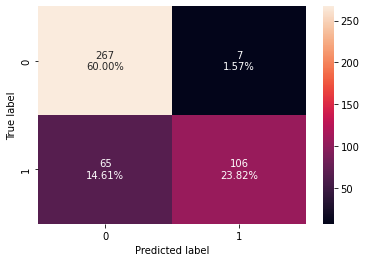

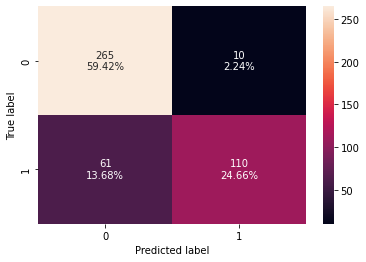

In [103]:
confusion_matrix_sklearn(xgb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned,X_val,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned, xtest=X_val, ytest=y_val)

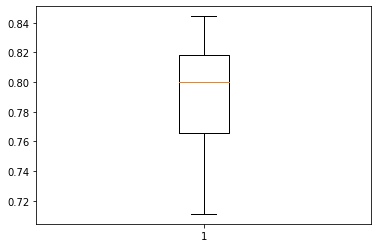

SCORE: Mean = 79.34%, Standard Deviation = 4.03%
95% Confidence Interval: 71.27% to 87.41%.


In [104]:
results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

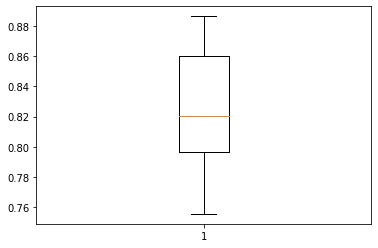

SCORE: Mean = 82.08%, Standard Deviation = 4.3%
95% Confidence Interval: 73.47% to 90.68%.


In [105]:
results = cross_val_score(xgb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [106]:
FinalModel = pd.DataFrame([test,xgb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('file.csv',index=False)

## Made some amazing progress with this model!!! Score: 0.77990, boosted my ranking to 2694!!!

#### Next, I will try going back to the original data & manipulating Fare to normalize it.

In [107]:
titanic_fare_manip = pd.read_csv('/kaggle/input/titanic/train.csv')

test_fare_manip = pd.read_csv('/kaggle/input/titanic/test.csv')

In [108]:
titanic_fare_manip.drop('PassengerId',axis=1,inplace=True)

titanic_fare_manip.drop('Name',axis=1,inplace=True)
test_fare_manip.drop('Name',axis=1,inplace=True)

titanic_fare_manip.drop('Ticket',axis=1,inplace=True)
test_fare_manip.drop('Ticket',axis=1,inplace=True)

titanic_fare_manip.drop('Cabin',axis=1,inplace=True)
test_fare_manip.drop('Cabin',axis=1,inplace=True)

sex = {'male':0,'female':1}
titanic_fare_manip['Sex'] = titanic_fare_manip['Sex'].map(sex)
test_fare_manip['Sex'] = test_fare_manip['Sex'].map(sex)
embark = {'C':0,'Q':1,'S':2}
titanic_fare_manip['Embarked'] = titanic_fare_manip['Embarked'].map(embark)
test_fare_manip['Embarked'] = test_fare_manip['Embarked'].map(embark)

In [109]:
histobox(titanic_fare_manip,x='Fare')

## Fare has a very skewed distribution. I will attempt to fix it:

In [110]:
np.log(1+(np.log((titanic_fare_manip['Fare'])+1)))

0      1.134691
1      1.664038
2      1.159662
3      1.607603
4      1.164014
         ...   
886    1.291725
887    1.489299
888    1.434282
889    1.489299
890    1.153433
Name: Fare, Length: 891, dtype: float64

In [111]:
histobox(pd.DataFrame((np.log((titanic_fare_manip['Fare'])+1))),'Fare')
histobox(pd.DataFrame(np.arcsinh((titanic_fare_manip['Fare']))),'Fare')
histobox(pd.DataFrame(np.sqrt((titanic_fare_manip['Fare']))),'Fare')

## The best data transformation is log(Fare+1). Let's apply it to the data and the test set.

In [112]:
titanic_fare_manip['Fare_log2'] = np.log((titanic_fare_manip['Fare'])+1)

test_fare_manip['Fare_log2'] = np.log((test_fare_manip['Fare'])+1)

In [113]:
histobox(test_fare_manip,'Fare_log2')

In [114]:
titanic_fare_manip.drop('Fare',axis=1,inplace=True)
test_fare_manip.drop('Fare',axis=1,inplace=True)

## Let's redo the pipelines, standardization, and outlier fixing.

In [115]:
modeltest = test_fare_manip.copy()
test_fare_manip = test_fare_manip['PassengerId'] #preparation for the final csv file.
modeltest.drop(['PassengerId'],axis=1,inplace=True)

X = titanic_fare_manip.drop('Survived',axis=1)
y = titanic_fare_manip['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y
)

numerical_list=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare_log2']
categorical_list=['Embarked']

X_train_num = X_train[numerical_list]
X_val_num = X_val[numerical_list]
X_test_num = modeltest[numerical_list]

X_train_cat = X_train[categorical_list]
X_val_cat = X_val[categorical_list]
X_test_cat = modeltest[categorical_list]

list_of_dicts = [embark]
Dummy=['Embarked']
def categorical_imputing_WITH_dummies(X_train_cat, X_val_cat, X_test_cat):
    cat_pipeline = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=5)) #change n_neighbors as needed
    X_train_cat = pd.DataFrame(cat_pipeline.fit_transform(X_train_cat),columns=categorical_list)
    X_val_cat = pd.DataFrame(cat_pipeline.transform(X_val_cat),columns=categorical_list)
    X_test_cat = pd.DataFrame(cat_pipeline.transform(X_test_cat),columns=categorical_list)

    def inverse_mapping(x, y):
        inv_dict = {v: k for k, v in x.items()}
        X_train_cat[y] = np.round(X_train_cat[y]).map(inv_dict).astype("category")
        X_val_cat[y] = np.round(X_val_cat[y]).map(inv_dict).astype("category")
        X_test_cat[y] = np.round(X_test_cat[y]).map(inv_dict).astype("category")

    count=0
    for item in list_of_dicts:
        inverse_mapping(item,Dummy[count])
        count = count+1

    X_train_cat = pd.get_dummies(X_train_cat, drop_first=False)
    X_val_cat = pd.get_dummies(X_val_cat, drop_first=False)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first=False)

    return [X_train_cat, X_val_cat, X_test_cat]

[X_train_cat, X_val_cat, X_test_cat] = categorical_imputing_WITH_dummies(X_train_cat, X_val_cat, X_test_cat)

num_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan,strategy='median'),
                 StandardScaler()
)
X_train_num = pd.DataFrame(num_pipeline.fit_transform(X_train_num),columns=numerical_list)
X_val_num = pd.DataFrame(num_pipeline.transform(X_val_num),columns=numerical_list)
X_test_num = pd.DataFrame(num_pipeline.transform(X_test_num),columns=numerical_list)

column_list=['Fare_log2']

for column in column_list:
    for DATA in [X_train_num,X_val_num,X_test_num]:
        list_ = six_iqr_outlier_list(DATA,column).index.tolist()
        for item in list_:
            if DATA.iloc[item,DATA.columns.get_loc(column)] > DATA[column].median():
                DATA.iloc[item,DATA.columns.get_loc(column)]=np.quantile(DATA[column][DATA[column].notnull()],[.25,.75])[1]
            else:
                DATA.iloc[item,DATA.columns.get_loc(column)]=np.quantile(DATA[column][DATA[column].notnull()],[.25,.75])[0]

X_train = pd.concat([X_train_num,X_train_cat],axis=1)
X_val = pd.concat([X_val_num,X_val_cat],axis=1)
X_test = pd.concat([X_test_num,X_test_cat],axis=1)

In [116]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")



def get_metrics_score(model,X_train=X_train,xtest=X_test,ytest=y_val,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 

    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(xtest)

    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(xtest,ytest)

    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(ytest,pred_test)

    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(ytest,pred_test)

    #F1 of the model (higher F1 = lower rate of incorrect TRUE predictions)
    #A lower rate of incorrect TRUEs implies a better predicting dataset overall. invF1 does the same.
    #For data where 0's and 1's are equally important, it's best to have high F1 & invF1.
    train_f1 = metrics.f1_score(y_train,pred_train)
    test_f1 = metrics.f1_score(ytest,pred_test)

    #Specificity of the model
    train_specificity = metrics.recall_score(y_train,pred_train,pos_label=0)
    test_specificity = metrics.recall_score(ytest,pred_test,pos_label=0)

    #NPV of the model (Negative Predictive Value)
    train_npv = metrics.precision_score(y_train,pred_train,pos_label=0)
    test_npv = metrics.precision_score(ytest,pred_test,pos_label=0)

    #Harmonic Mean of Specificity + NPV of the model (higher invF1 = lower rate of incorrect FALSE predictions)
    #A lower rate of incorrect FALSEs implies a better predicting dataset overall. F1 does the same.
    #For data where 0's and 1's are equally important, it's best to have high F1 & invF1.
        # I call it invF1 for short because we're inverting the 0's and 1's, 
        # NOT because we're inverting the harmonic mean.
    train_invF1 = metrics.f1_score(y_train,pred_train,pos_label=0)
    test_invF1 = metrics.f1_score(ytest,pred_test,pos_label=0)

    #Harmonic Mean of F1 and invF1. Most useful metric when both 0 and 1 are important.
    train_F1_invF1_harmmean = 2/((train_f1**-1)+(train_invF1**-1))
    test_F1_invF1_harmmean = 2/((test_f1**-1)+(test_invF1**-1))

    score_list.extend((train_acc,
                       test_acc,
                       train_recall,
                       test_recall,
                       train_precision,
                       test_precision,
                       train_f1,
                       test_f1,
                       train_specificity,
                       test_specificity,
                       train_npv,
                       test_npv,
                       train_invF1,
                       test_invF1,
                       train_F1_invF1_harmmean,
                       test_F1_invF1_harmmean))

    print("These metrics are performed on the Validation set.\n")

    # If the flag is set to True then only the following print statements will be dispayed.
    # The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on val/test set : ",model.score(xtest,ytest))
        print("")
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on val/test set : ",metrics.recall_score(ytest,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on val/test set : ",metrics.precision_score(ytest,pred_test))
        print("F1 on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1 on val/test set : ",metrics.f1_score(ytest,pred_test))
        print("")
        print("Specificity on training set : ",metrics.recall_score(y_train,pred_train,pos_label=0))
        print("Specificity on val/test set : ",metrics.recall_score(ytest,pred_test,pos_label=0))
        print("NPV on training set : ",metrics.precision_score(y_train,pred_train,pos_label=0))
        print("NPV on val/test set : ",metrics.precision_score(ytest,pred_test,pos_label=0))
        print("Inverted F1 on training set : ",metrics.f1_score(y_train,pred_train,pos_label=0))
        print("Inverted F1 on val/test set : ",metrics.f1_score(ytest,pred_test,pos_label=0))
        print("")
        print("Harmonic Mean of F1 and Inverted F1 on train set : ",2/((train_f1**-1)+(train_invF1**-1)))
        print("Harmonic Mean of F1 and Inverted F1 on val/test set : ",2/((test_f1**-1)+(test_invF1**-1)))

    return score_list # returning the list with train and val/test scores

## Now, let's redo our two best models: Gradient Boost and XGBoost.

# GradientBoost

These metrics are performed on the Validation set.

Accuracy on training set :  0.9235955056179775
Accuracy on val/test set :  0.8094170403587444

Recall on training set :  0.8421052631578947
Recall on val/test set :  0.7017543859649122
Precision on training set :  0.9536423841059603
Precision on val/test set :  0.7792207792207793
F1 on training set :  0.8944099378881988
F1 on val/test set :  0.7384615384615385

Specificity on training set :  0.9744525547445255
Specificity on val/test set :  0.8763636363636363
NPV on training set :  0.9081632653061225
NPV on val/test set :  0.8253424657534246
Inverted F1 on training set :  0.9401408450704225
Inverted F1 on val/test set :  0.8500881834215167

Harmonic Mean of F1 and Inverted F1 on train set :  0.9167054111083296
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7903528849110103


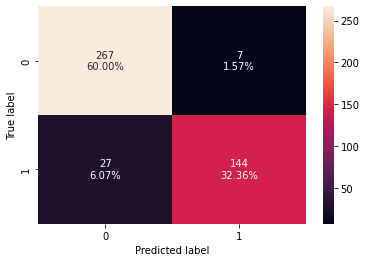

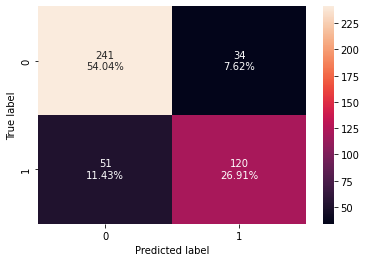

In [117]:
gb_classifier=GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

confusion_matrix_sklearn(gb_classifier,X_train,y_train)

confusion_matrix_sklearn(gb_classifier,X_val,y_val)

gb_classifier_pretune = get_metrics_score(gb_classifier, xtest=X_val, ytest=y_val)

# GradientBoost Hyperparameter Tuning:

## I have created a new method for randomizedsearch so that we don't reuse a single set of parameters multiple times.



In [118]:
from sklearn.model_selection import ParameterGrid
from numpy import random

# Importing stuff I'll need for a better hyperparameter search method.

In [119]:
list_of_indices = []
low = 0
count = 0

def accuracy_train_val_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    y_pred_val = estimator.predict(X_val)
    train_acc = metrics.accuracy_score(y_true,y_pred)
    val_acc = metrics.accuracy_score(y_val,y_pred_val)
    avg_acc = (train_acc + val_acc)/2
    acc_diff = (1-np.abs(train_acc-val_acc))**1 #higher powers == higher emphasis on closer accuracies

    return ((2*avg_acc)+(1*acc_diff))/3


gb_classifier_tuned = GradientBoostingClassifier(random_state=1)

parameters = {
    "n_estimators": [100],
    "subsample": [0.4],
    "max_features":[None],
    "min_samples_leaf": [0.01],
    "min_samples_split": [0.2],
    "learning_rate" : [0.1]
}

param_grid=ParameterGrid(parameters)
acc_scorer = scoring

for entry in range(len(list(param_grid))):
    list_of_indices.append(entry)

    The highest val/train/diff accuracy is 0.8878923766816142. Iteration: 44
    CPU times: user 6.72 s, sys: 35.1 ms, total: 6.76 s
    Wall time: 9.66 s
    {'subsample': 0.4,
    'n_estimators': 100,
    'min_samples_split': 0.2,
    'min_samples_leaf': 0.01,
    'max_features': None,
    'learning_rate': 0.1}

    Accuracy on training set :  0.8629213483146068
    Accuracy on val/test set :  0.8318385650224215

    SCORE: Mean = 81.13%, Standard Deviation = 5.79%
    95% Confidence Interval: 69.54% to 92.72%.

    SCORE: Mean = 80.52%, Standard Deviation = 6.99%
    95% Confidence Interval: 66.53% to 94.5%.

In [120]:
%%time
low=0
while low < 0.1: #change this to the next best average
    if len(list_of_indices) > 0:
        rand = random.randint(0,len(list_of_indices))
        rand = list_of_indices[rand]
        count = count+1
        """
        We append and use a random number as an index for our param_grid if and only if we haven't seen it yet.
        """
        list_of_indices.remove(rand)
        current_parameter = list(param_grid)[rand]
        for entry in range(len(current_parameter.keys())):
            current_parameter.update({list(current_parameter.keys())[entry]:[current_parameter[list(current_parameter.keys())[entry]]]})

        """
        Now we actually search for an optimal param_distribution using the parameter combo corresponding to the random index we pulled.
        """

        grid_obj = RandomizedSearchCV(gb_classifier_tuned, param_distributions = current_parameter, n_iter=1, scoring=acc_scorer,cv=2, n_jobs=-1)
        grid_obj = grid_obj.fit(X_train, y_train)

        gb_classifier_tuned = grid_obj.best_estimator_

        gb_classifier_tuned.fit(X_train, y_train)

        """
        Finally, we check the custom scorer. If 'low' is below the specified while loop amount, we go again.
        If not, the loop stops here and prints 'low' and the # of iterations the loop took to find this score.

        If no param_distribution with a better score than specified exists, it will loop until all indices are checked,
            at which point the loop will terminate with a print.
        """            
        low = accuracy_train_val_scorer(gb_classifier_tuned,X_train,y_train)
    else:
        low = 777

if len(list_of_indices) > 0:
    print(f"The highest val/train/diff accuracy is {low}. Iteration: {count}")
else:
    print(f'There were no parameter combinations which were better than the given "low" score. Iteration: {count}')
    
grid_obj.best_params_

There were no parameter combinations which were better than the given "low" score. Iteration: 1
CPU times: user 179 ms, sys: 1.94 ms, total: 181 ms
Wall time: 283 ms


{'subsample': 0.4,
 'n_estimators': 100,
 'min_samples_split': 0.2,
 'min_samples_leaf': 0.01,
 'max_features': None,
 'learning_rate': 0.1}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8629213483146068
Accuracy on val/test set :  0.8318385650224215

Recall on training set :  0.783625730994152
Recall on val/test set :  0.7602339181286549
Precision on training set :  0.8481012658227848
Precision on val/test set :  0.7926829268292683
F1 on training set :  0.8145896656534954
F1 on val/test set :  0.7761194029850745

Specificity on training set :  0.9124087591240876
Specificity on val/test set :  0.8763636363636363
NPV on training set :  0.8710801393728222
NPV on val/test set :  0.8546099290780141
Inverted F1 on training set :  0.8912655971479501
Inverted F1 on val/test set :  0.8653500897666068

Harmonic Mean of F1 and Inverted F1 on train set :  0.8512043906901107
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8183094452969407


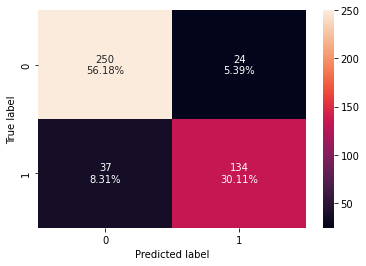

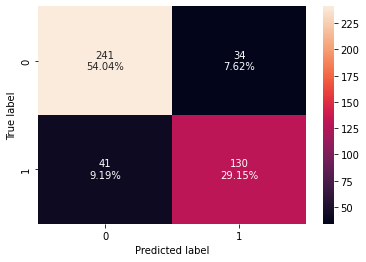

In [121]:
confusion_matrix_sklearn(gb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(gb_classifier_tuned,X_val,y_val)

gb_classifier_posttune = get_metrics_score(gb_classifier_tuned,xtest=X_val, ytest=y_val)

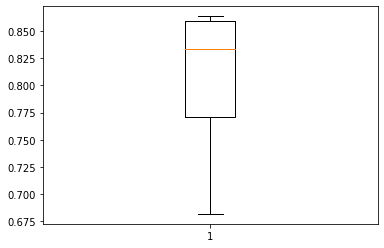

SCORE: Mean = 81.13%, Standard Deviation = 5.79%
95% Confidence Interval: 69.54% to 92.72%.


In [122]:
results = cross_val_score(gb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

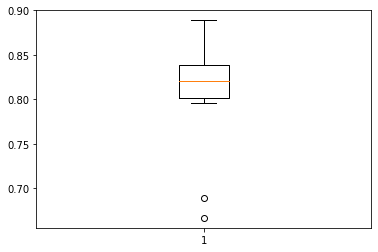

SCORE: Mean = 80.52%, Standard Deviation = 6.99%
95% Confidence Interval: 66.53% to 94.5%.


In [123]:
results = cross_val_score(gb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [124]:
FinalModel = pd.DataFrame([test,gb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('file.csv',index=False)

## This GradientBoost went up to 0.77751 on the test set! A slight increase from the first GradientBoost, but a boost nonetheless. Let's try XGBoost with my new hyperparameter tuning method.

In [125]:
xgb_classifier=XGBClassifier(random_state=1)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [126]:
list_of_indices = []
count = 0

def accuracy_train_val_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    y_pred_val = estimator.predict(X_val)
    train_acc = metrics.accuracy_score(y_true,y_pred)
    val_acc = metrics.accuracy_score(y_val,y_pred_val)
    avg_acc = (train_acc + val_acc)/2
    acc_diff = (1-np.abs(train_acc-val_acc))**1 #higher powers == higher emphasis on closer accuracies

    return ((2*avg_acc)+(1*acc_diff))/3 #adjust multipliers to shift weight... change the divisor accordingly


xgb_classifier_tuned = XGBClassifier(random_state=1)

parameters = {
    "n_estimators": [80],
    "scale_pos_weight": [1.2],
    "subsample": [0.9],
    "learning_rate": [0.4],
    "gamma": [7], 
    "colsample_bytree": [1],
    "colsample_bylevel": [1.0],
    "colsample_bynode": [0.3],
}

param_grid=ParameterGrid(parameters)
acc_scorer = scoring

for entry in range(len(list(param_grid))):
    list_of_indices.append(entry)

print(f'Total # of iterations: {len(list(param_grid))}')

Total # of iterations: 1


    The highest val/train/diff accuracy is 0.8938714499252617. Iteration: 594
    CPU times: user 29min 39s, sys: 22 s, total: 30min 1s
    Wall time: 10min 46s
    {'subsample': 0.9,
    'scale_pos_weight': 1.2000000000000002,
    'n_estimators': 80,
    'learning_rate': 0.4,
    'gamma': 7,
    'colsample_bytree': 1,
    'colsample_bynode': 0.30000000000000004,
    'colsample_bylevel': 1.0}

    Accuracy on training set :  0.8449438202247191
    Accuracy on val/test set :  0.8408071748878924

    SCORE: Mean = 80.02%, Standard Deviation = 5.85%
    95% Confidence Interval: 68.32% to 91.71%.

    SCORE: Mean = 80.31%, Standard Deviation = 5.79%
    95% Confidence Interval: 68.73% to 91.88%.

In [127]:
%%time

low = 0
while low < 0.84860986546:
    if len(list_of_indices) > 0:
        rand = random.randint(0,len(list_of_indices))
        rand = list_of_indices[rand]
        count = count+1
        """
        We append and use a random number as an index for our param_grid if and only if we haven't seen it yet.
        """
        list_of_indices.remove(rand)
        current_parameter = list(param_grid)[rand]
        for entry in range(len(current_parameter.keys())):
            current_parameter.update(
            {list(current_parameter.keys())[entry]:[current_parameter[list(current_parameter.keys())[entry]]]})

        """
        Now we actually search for an optimal param_distribution using the parameter
        combo corresponding to the random index we pulled.
        """

        grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions = current_parameter,
        n_iter=1, scoring=acc_scorer,cv=2, n_jobs=-1)
        grid_obj = grid_obj.fit(X_train, y_train)

        xgb_classifier_tuned = grid_obj.best_estimator_

        xgb_classifier_tuned.fit(X_train, y_train)

        """
        Finally, we check the custom scorer. If 'low' is below the specified while loop amount, we go again.
        If not, the loop stops here and prints 'low' and the # of iterations the loop took to find this score.

        If no param_distribution with a better score than specified exists, it will loop until all indices
            are checked, at which point the loop will terminate with a print.
        """            
        low = accuracy_train_val_scorer(xgb_classifier_tuned,X_train,y_train)
    else:
        low = 777

if len(list_of_indices) > 0:
    print(f"The highest val/train/diff accuracy is {low}. Iteration: {count}")
else:
    print(f'There were no parameter combinations which were better than the given "low" score. Iteration: {count}')
grid_obj.best_params_

There were no parameter combinations which were better than the given "low" score. Iteration: 1
CPU times: user 1.87 s, sys: 21.4 ms, total: 1.89 s
Wall time: 724 ms


{'subsample': 0.9,
 'scale_pos_weight': 1.2,
 'n_estimators': 80,
 'learning_rate': 0.4,
 'gamma': 7,
 'colsample_bytree': 1,
 'colsample_bynode': 0.3,
 'colsample_bylevel': 1.0}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8449438202247191
Accuracy on val/test set :  0.8408071748878924

Recall on training set :  0.7134502923976608
Recall on val/test set :  0.7309941520467836
Precision on training set :  0.8591549295774648
Precision on val/test set :  0.8333333333333334
F1 on training set :  0.779552715654952
F1 on val/test set :  0.778816199376947

Specificity on training set :  0.927007299270073
Specificity on val/test set :  0.9090909090909091
NPV on training set :  0.8382838283828383
NPV on val/test set :  0.8445945945945946
Inverted F1 on training set :  0.8804159445407279
Inverted F1 on val/test set :  0.8756567425569177

Harmonic Mean of F1 and Inverted F1 on train set :  0.8269199978651866
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8244023083264632


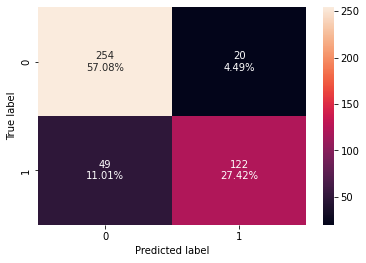

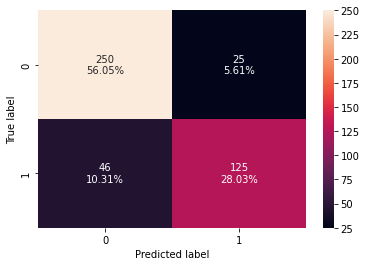

In [128]:
confusion_matrix_sklearn(xgb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned,X_val,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned, xtest=X_val, ytest=y_val)

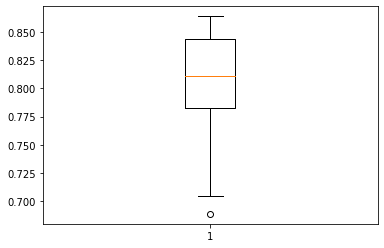

SCORE: Mean = 80.02%, Standard Deviation = 5.85%
95% Confidence Interval: 68.32% to 91.71%.


In [129]:
results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

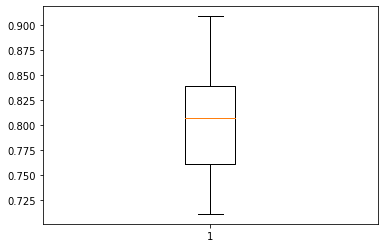

SCORE: Mean = 80.31%, Standard Deviation = 5.79%
95% Confidence Interval: 68.73% to 91.88%.


In [130]:
results = cross_val_score(xgb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [131]:
FinalModel = pd.DataFrame([test,xgb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('xgfile.csv',index=False)

## Disappointingly, all attempts at making a better XGBoost model have failed so far.
## Something I noticed from my older, better XGBoost model is that Recall was lower and Specificity was higher. Let's edit my scorer to favor specificity increases over recall.

In [132]:
list_of_indices = []
count = 0

def accuracy_train_val_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    y_pred_val = estimator.predict(X_val)
    
    train_recall = metrics.recall_score(y_true,y_pred)
    val_recall = metrics.recall_score(y_val,y_pred_val)
    
    train_spec = metrics.recall_score(y_true,y_pred,pos_label=0)
    val_spec = metrics.recall_score(y_val,y_pred_val,pos_label=0)
    
    avg_recall = (train_recall + val_recall)/2
    avg_spec = (train_spec + val_spec)/2
    acc_diff_recall = (1-np.abs(train_recall - val_recall))**1 
    acc_diff_spec = (1-np.abs(train_spec - val_spec))**1 

    return ((((2*avg_recall)+(1*acc_diff_recall))/3)+(3*(((2*avg_spec)+(1*acc_diff_spec))/3)))/4 


xgb_classifier_tuned = XGBClassifier(random_state=1)

parameters = {
    "n_estimators": [500],
    "scale_pos_weight": [1.0],
    "subsample": [0.9],
    "learning_rate": [0.4],
    "gamma": [7], 
    "colsample_bytree": [1.0],
    "colsample_bylevel": [1.0],
    "colsample_bynode": [1.0],
}

param_grid=ParameterGrid(parameters)
acc_scorer = scoring

for entry in range(len(list(param_grid))):
    list_of_indices.append(entry)

print(f'Total # of iterations: {len(list(param_grid))}')

Total # of iterations: 1


    The highest val/train/diff accuracy is 0.9167783094098885. Iteration: 4
    CPU times: user 11.8 s, sys: 212 ms, total: 12 s
    Wall time: 4.24 s
    {'subsample': 0.9,
    'scale_pos_weight': 1.0,
    'n_estimators': 500,
    'learning_rate': 0.4,
    'gamma': 7,
    'colsample_bytree': 1.0,
    'colsample_bynode': 1.0,
    'colsample_bylevel': 1.0}

    Accuracy on training set :  0.8404494382022472
    Accuracy on val/test set :  0.8408071748878924

    SCORE: Mean = 80.67%, Standard Deviation = 3.55%
    95% Confidence Interval: 73.56% to 87.78%.

    SCORE: Mean = 82.76%, Standard Deviation = 4.6%
    95% Confidence Interval: 73.57% to 91.96%.

In [133]:
%%time

low = 0
while low < 0.9166:
    if len(list_of_indices) > 0:
        rand = random.randint(0,len(list_of_indices))
        rand = list_of_indices[rand]
        count = count+1
        """
        We append and use a random number as an index for our param_grid if and only if we haven't seen it yet.
        """
        list_of_indices.remove(rand)
        current_parameter = list(param_grid)[rand]
        for entry in range(len(current_parameter.keys())):
            current_parameter.update(
            {list(current_parameter.keys())[entry]:[current_parameter[list(current_parameter.keys())[entry]]]})

        """
        Now we actually search for an optimal param_distribution using the parameter
        combo corresponding to the random index we pulled.
        """

        grid_obj = RandomizedSearchCV(xgb_classifier_tuned, param_distributions = current_parameter,
        n_iter=1, scoring=acc_scorer,cv=2, n_jobs=-1)
        grid_obj = grid_obj.fit(X_train, y_train)

        xgb_classifier_tuned = grid_obj.best_estimator_

        xgb_classifier_tuned.fit(X_train, y_train)

        """
        Finally, we check the custom scorer. If 'low' is below the specified while loop amount, we go again.
        If not, the loop stops here and prints 'low' and the # of iterations the loop took to find this score.

        If no param_distribution with a better score than specified exists, it will loop until all indices
            are checked, at which point the loop will terminate with a print.
        """            
        low = accuracy_train_val_scorer(xgb_classifier_tuned,X_train,y_train)
    else:
        low = 777

if len(list_of_indices) > 0:
    print(f"The highest val/train/diff accuracy is {low}. Iteration: {count}")
else:
    print(f'There were no parameter combinations which were better than the given "low" score. Iteration: {count}')
grid_obj.best_params_

There were no parameter combinations which were better than the given "low" score. Iteration: 1
CPU times: user 10.9 s, sys: 217 ms, total: 11.1 s
Wall time: 3.99 s


{'subsample': 0.9,
 'scale_pos_weight': 1.0,
 'n_estimators': 500,
 'learning_rate': 0.4,
 'gamma': 7,
 'colsample_bytree': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bylevel': 1.0}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8404494382022472
Accuracy on val/test set :  0.8408071748878924

Recall on training set :  0.631578947368421
Recall on val/test set :  0.6549707602339181
Precision on training set :  0.9310344827586207
Precision on val/test set :  0.9032258064516129
F1 on training set :  0.7526132404181184
F1 on val/test set :  0.759322033898305

Specificity on training set :  0.9708029197080292
Specificity on val/test set :  0.9563636363636364
NPV on training set :  0.8085106382978723
NPV on val/test set :  0.8167701863354038
Inverted F1 on training set :  0.8822553897180763
Inverted F1 on val/test set :  0.8810720268006701

Harmonic Mean of F1 and Inverted F1 on train set :  0.8122941201419422
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8156788901273113


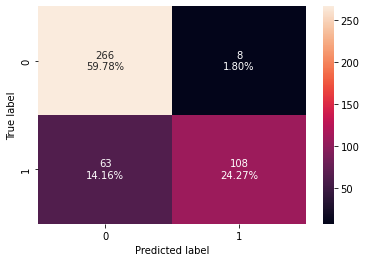

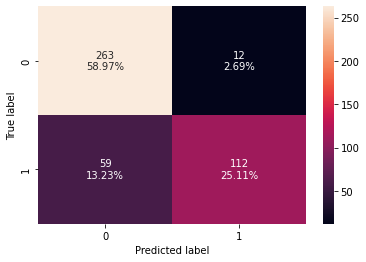

In [134]:
confusion_matrix_sklearn(xgb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(xgb_classifier_tuned,X_val,y_val)

xgb_classifier_posttune = get_metrics_score(xgb_classifier_tuned, xtest=X_val, ytest=y_val)

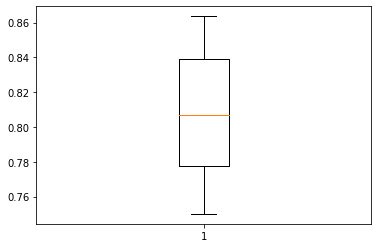

SCORE: Mean = 80.67%, Standard Deviation = 3.55%
95% Confidence Interval: 73.56% to 87.78%.


In [135]:
results = cross_val_score(xgb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

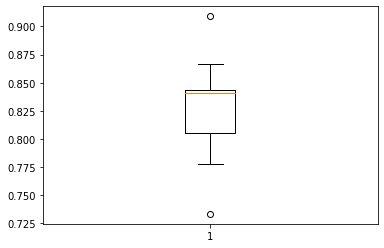

SCORE: Mean = 82.76%, Standard Deviation = 4.6%
95% Confidence Interval: 73.57% to 91.96%.


In [136]:
results = cross_val_score(xgb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [137]:
FinalModel = pd.DataFrame([test,xgb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('file.csv',index=False)

## Again, no better than the best XGBoost model that got me 2700th place.

## Overall, this last model is better for generalizations, as the Cross Validations on the train and val sets are quite good and the accuracies are better.

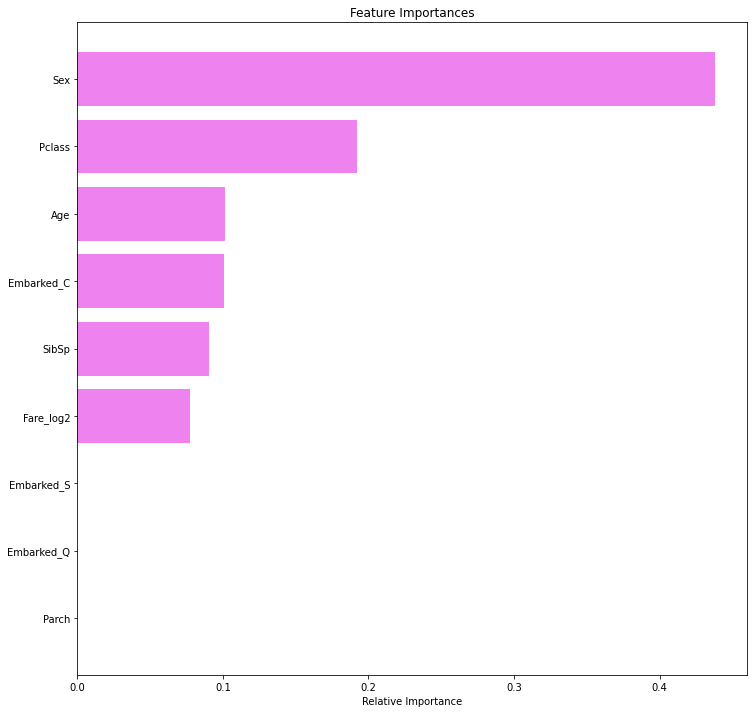

In [138]:
feature_names = X_train.columns
importances = xgb_classifier_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Last chance: I'm gonna use GradientBoost with my best XGBoost Classifier:

In [139]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')

test.drop('Name',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)
test.drop('Cabin',axis=1,inplace=True)

sex = {'male':0,'female':1}
test['Sex'] = test['Sex'].map(sex)
embark = {'C':0,'Q':1,'S':2}
test['Embarked'] = test['Embarked'].map(embark)


modeltest = test.copy()
test = test['PassengerId'] #preparation for the final csv file.
modeltest.drop(['PassengerId'],axis=1,inplace=True)

X = titanic.drop('Survived',axis=1)
y = titanic['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y
)

numerical_list=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_list=['Embarked']

X_train_num = X_train[numerical_list]
X_val_num = X_val[numerical_list]
X_test_num = modeltest[numerical_list]

X_train_cat = X_train[categorical_list]
X_val_cat = X_val[categorical_list]
X_test_cat = modeltest[categorical_list]

list_of_dicts = [embark]
Dummy=['Embarked']
def categorical_imputing_WITH_dummies(X_train_cat, X_val_cat, X_test_cat):
    cat_pipeline = make_pipeline(KNNImputer(missing_values=np.nan, n_neighbors=5)) #change n_neighbors as needed
    X_train_cat = pd.DataFrame(cat_pipeline.fit_transform(X_train_cat),columns=categorical_list)
    X_val_cat = pd.DataFrame(cat_pipeline.transform(X_val_cat),columns=categorical_list)
    X_test_cat = pd.DataFrame(cat_pipeline.transform(X_test_cat),columns=categorical_list)

    def inverse_mapping(x, y):
        inv_dict = {v: k for k, v in x.items()}
        X_train_cat[y] = np.round(X_train_cat[y]).map(inv_dict).astype("category")
        X_val_cat[y] = np.round(X_val_cat[y]).map(inv_dict).astype("category")
        X_test_cat[y] = np.round(X_test_cat[y]).map(inv_dict).astype("category")

    count=0
    for item in list_of_dicts:
        inverse_mapping(item,Dummy[count])
        count = count+1

    X_train_cat = pd.get_dummies(X_train_cat, drop_first=False)
    X_val_cat = pd.get_dummies(X_val_cat, drop_first=False)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first=False)

    return [X_train_cat, X_val_cat, X_test_cat]

[X_train_cat, X_val_cat, X_test_cat] = categorical_imputing_WITH_dummies(X_train_cat, X_val_cat, X_test_cat)

num_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan,strategy='median'),
                 StandardScaler()
)
X_train_num = pd.DataFrame(num_pipeline.fit_transform(X_train_num),columns=numerical_list)
X_val_num = pd.DataFrame(num_pipeline.transform(X_val_num),columns=numerical_list)
X_test_num = pd.DataFrame(num_pipeline.transform(X_test_num),columns=numerical_list)

column_list=['Fare']

for column in column_list:
    for DATA in [X_train_num,X_val_num,X_test_num]:
        list_ = six_iqr_outlier_list(DATA,column).index.tolist()
        for item in list_:
            if DATA.iloc[item,DATA.columns.get_loc(column)] > DATA[column].median():
                DATA.iloc[item,DATA.columns.get_loc(column)]=np.quantile(DATA[column][DATA[column].notnull()],[.25,.75])[1]
            else:
                DATA.iloc[item,DATA.columns.get_loc(column)]=np.quantile(DATA[column][DATA[column].notnull()],[.25,.75])[0]

X_train = pd.concat([X_train_num,X_train_cat],axis=1)
X_val = pd.concat([X_val_num,X_val_cat],axis=1)
X_test = pd.concat([X_test_num,X_test_cat],axis=1)

In [140]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")



def get_metrics_score(model,X_train=X_train,xtest=X_test,ytest=y_val,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 

    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(xtest)

    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(xtest,ytest)

    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(ytest,pred_test)

    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(ytest,pred_test)

    #F1 of the model (higher F1 = lower rate of incorrect TRUE predictions)
    #A lower rate of incorrect TRUEs implies a better predicting dataset overall. invF1 does the same.
    #For data where 0's and 1's are equally important, it's best to have high F1 & invF1.
    train_f1 = metrics.f1_score(y_train,pred_train)
    test_f1 = metrics.f1_score(ytest,pred_test)

    #Specificity of the model
    train_specificity = metrics.recall_score(y_train,pred_train,pos_label=0)
    test_specificity = metrics.recall_score(ytest,pred_test,pos_label=0)

    #NPV of the model (Negative Predictive Value)
    train_npv = metrics.precision_score(y_train,pred_train,pos_label=0)
    test_npv = metrics.precision_score(ytest,pred_test,pos_label=0)

    #Harmonic Mean of Specificity + NPV of the model (higher invF1 = lower rate of incorrect FALSE predictions)
    #A lower rate of incorrect FALSEs implies a better predicting dataset overall. F1 does the same.
    #For data where 0's and 1's are equally important, it's best to have high F1 & invF1.
        # I call it invF1 for short because we're inverting the 0's and 1's, 
        # NOT because we're inverting the harmonic mean.
    train_invF1 = metrics.f1_score(y_train,pred_train,pos_label=0)
    test_invF1 = metrics.f1_score(ytest,pred_test,pos_label=0)

    #Harmonic Mean of F1 and invF1. Most useful metric when both 0 and 1 are important.
    train_F1_invF1_harmmean = 2/((train_f1**-1)+(train_invF1**-1))
    test_F1_invF1_harmmean = 2/((test_f1**-1)+(test_invF1**-1))

    score_list.extend((train_acc,
                       test_acc,
                       train_recall,
                       test_recall,
                       train_precision,
                       test_precision,
                       train_f1,
                       test_f1,
                       train_specificity,
                       test_specificity,
                       train_npv,
                       test_npv,
                       train_invF1,
                       test_invF1,
                       train_F1_invF1_harmmean,
                       test_F1_invF1_harmmean))

    print("These metrics are performed on the Validation set.\n")

    # If the flag is set to True then only the following print statements will be dispayed.
    # The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on val/test set : ",model.score(xtest,ytest))
        print("")
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on val/test set : ",metrics.recall_score(ytest,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on val/test set : ",metrics.precision_score(ytest,pred_test))
        print("F1 on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1 on val/test set : ",metrics.f1_score(ytest,pred_test))
        print("")
        print("Specificity on training set : ",metrics.recall_score(y_train,pred_train,pos_label=0))
        print("Specificity on val/test set : ",metrics.recall_score(ytest,pred_test,pos_label=0))
        print("NPV on training set : ",metrics.precision_score(y_train,pred_train,pos_label=0))
        print("NPV on val/test set : ",metrics.precision_score(ytest,pred_test,pos_label=0))
        print("Inverted F1 on training set : ",metrics.f1_score(y_train,pred_train,pos_label=0))
        print("Inverted F1 on val/test set : ",metrics.f1_score(ytest,pred_test,pos_label=0))
        print("")
        print("Harmonic Mean of F1 and Inverted F1 on train set : ",2/((train_f1**-1)+(train_invF1**-1)))
        print("Harmonic Mean of F1 and Inverted F1 on val/test set : ",2/((test_f1**-1)+(test_invF1**-1)))

    return score_list # returning the list with train and val/test scores

These metrics are performed on the Validation set.

Accuracy on training set :  0.9325842696629213
Accuracy on val/test set :  0.8094170403587444

Recall on training set :  0.8596491228070176
Recall on val/test set :  0.7251461988304093
Precision on training set :  0.9607843137254902
Precision on val/test set :  0.7654320987654321
F1 on training set :  0.9074074074074074
F1 on val/test set :  0.7447447447447447

Specificity on training set :  0.9781021897810219
Specificity on val/test set :  0.8618181818181818
NPV on training set :  0.9178082191780822
NPV on val/test set :  0.8345070422535211
Inverted F1 on training set :  0.9469964664310954
Inverted F1 on val/test set :  0.8479427549194991

Harmonic Mean of F1 and Inverted F1 on train set :  0.9267793500123505
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.7930003980112927


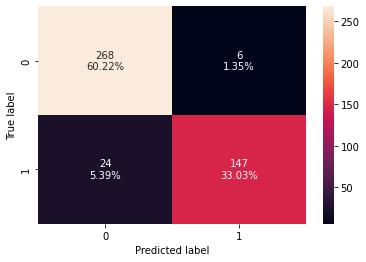

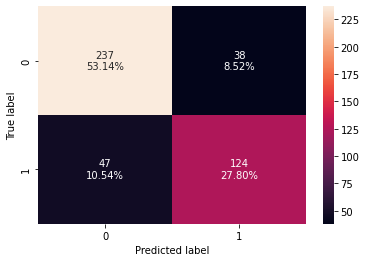

In [141]:
xgb_classifier=XGBClassifier(random_state=1,
    n_estimators = 320,
    scale_pos_weight = 0.8,
    subsample = 0.9,
    learning_rate = 0.1,
    gamma = 6,
    colsample_bytree = 0.8,
    colsample_bylevel = 0.6,
    colsample_bynode = 0.5
)
initial = xgb_classifier.fit(X_train,y_train)
gb_classifier=GradientBoostingClassifier(random_state=1,init = initial)
gb_classifier.fit(X_train,y_train)

confusion_matrix_sklearn(gb_classifier,X_train,y_train)

confusion_matrix_sklearn(gb_classifier,X_val,y_val)

gb_classifier_pretune = get_metrics_score(gb_classifier, xtest=X_val, ytest=y_val)

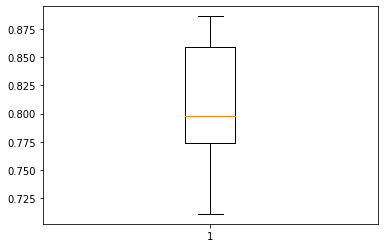

SCORE: Mean = 80.71%, Standard Deviation = 5.31%
95% Confidence Interval: 70.09% to 91.32%.


In [142]:
results = cross_val_score(gb_classifier,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [171]:
list_of_indices = []
count = 0

def accuracy_train_val_scorer(estimator,X,y_true,greater_is_better=True):
    y_pred = estimator.predict(X)
    y_pred_val = estimator.predict(X_val)
    train_acc = metrics.accuracy_score(y_true,y_pred)
    val_acc = metrics.accuracy_score(y_val,y_pred_val)
    avg_acc = (train_acc + val_acc)/2
    acc_diff = (1-np.abs(train_acc-val_acc))**1

    return ((3*avg_acc)+(1*acc_diff))/4


gb_classifier_tuned = GradientBoostingClassifier(random_state=1,init=initial)

parameters = {
    "n_estimators": [230],
    "subsample":[0.51],
    "max_features":[0.9],
    "min_samples_leaf": [0.2],
    "min_samples_split": [0.2],
    "learning_rate" : [0.51]
}

param_grid=ParameterGrid(parameters)
acc_scorer = scoring

for entry in range(len(list(param_grid))):
    list_of_indices.append(entry)

print(f'Total # of iterations: {len(list(param_grid))}')

Total # of iterations: 1


    EXPERIMENTAL?? High accuracy, bad standard deviations on the Cross Vals.
    
    The highest val/train/diff accuracy is 0.8912159268403285. Iteration: 64
    CPU times: user 12min 15s, sys: 6.97 s, total: 12min 22s
    Wall time: 4min 49s
    {'subsample': 0.51,
    'n_estimators': 230,
    'min_samples_split': 0.2,
    'min_samples_leaf': 0.2,
    'max_features': 0.9,
    'learning_rate': 0.51}

    Accuracy on training set :  0.8584269662921349
    Accuracy on val/test set :  0.8542600896860987

    SCORE: Mean = 80.02%, Standard Deviation = 5.2%
    95% Confidence Interval: 69.61% to 90.43%.

    SCORE: Mean = 81.17%, Standard Deviation = 5.44%
    95% Confidence Interval: 70.29% to 92.06%.

In [172]:
%%time

low = 0
while low < 0.8912159268403284:
    if len(list_of_indices) > 0:
        rand = random.randint(0,len(list_of_indices))
        rand = list_of_indices[rand]
        count = count+1
        """
        We append and use a random number as an index for our param_grid if and only if we haven't seen it yet.
        """
        list_of_indices.remove(rand)
        current_parameter = list(param_grid)[rand]
        for entry in range(len(current_parameter.keys())):
            current_parameter.update(
            {list(current_parameter.keys())[entry]:[current_parameter[list(current_parameter.keys())[entry]]]})

        """
        Now we actually search for an optimal param_distribution using the parameter
        combo corresponding to the random index we pulled.
        """

        grid_obj = RandomizedSearchCV(gb_classifier_tuned, param_distributions = current_parameter,
        n_iter=1, scoring=acc_scorer,cv=2, n_jobs=-1)
        grid_obj = grid_obj.fit(X_train, y_train)

        gb_classifier_tuned = grid_obj.best_estimator_

        gb_classifier_tuned.fit(X_train, y_train)

        """
        Finally, we check the custom scorer. If 'low' is below the specified while loop amount, we go again.
        If not, the loop stops here and prints 'low' and the # of iterations the loop took to find this score.

        If no param_distribution with a better score than specified exists, it will loop until all indices
            are checked, at which point the loop will terminate with a print.
        """            
        low = accuracy_train_val_scorer(gb_classifier_tuned,X_train,y_train)
    else:
        low = 777

if len(list_of_indices) > 0:
    print(f"The highest val/train/diff accuracy is {low}. Iteration: {count}")
else:
    print(f'There were no parameter combinations which were better than the given "low" score. Iteration: {count}')
grid_obj.best_params_

There were no parameter combinations which were better than the given "low" score. Iteration: 1
CPU times: user 11.5 s, sys: 196 ms, total: 11.7 s
Wall time: 6.24 s


{'subsample': 0.51,
 'n_estimators': 230,
 'min_samples_split': 0.2,
 'min_samples_leaf': 0.2,
 'max_features': 0.9,
 'learning_rate': 0.51}

These metrics are performed on the Validation set.

Accuracy on training set :  0.8584269662921349
Accuracy on val/test set :  0.8542600896860987

Recall on training set :  0.7017543859649122
Recall on val/test set :  0.7076023391812866
Precision on training set :  0.9090909090909091
Precision on val/test set :  0.8897058823529411
F1 on training set :  0.792079207920792
F1 on val/test set :  0.7882736156351791

Specificity on training set :  0.9562043795620438
Specificity on val/test set :  0.9454545454545454
NPV on training set :  0.8370607028753994
NPV on val/test set :  0.8387096774193549
Inverted F1 on training set :  0.8926746166950597
Inverted F1 on val/test set :  0.8888888888888888

Harmonic Mean of F1 and Inverted F1 on train set :  0.8393736734612149
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8355632283124731


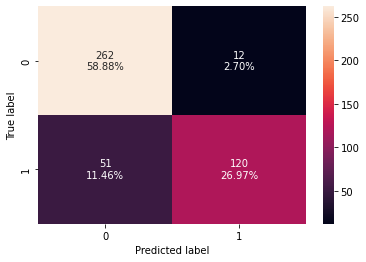

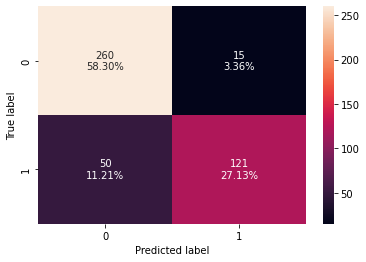

In [173]:
confusion_matrix_sklearn(gb_classifier_tuned,X_train,y_train)

confusion_matrix_sklearn(gb_classifier_tuned,X_val,y_val)

gb_classifier_posttune = get_metrics_score(gb_classifier_tuned, xtest=X_val, ytest=y_val)

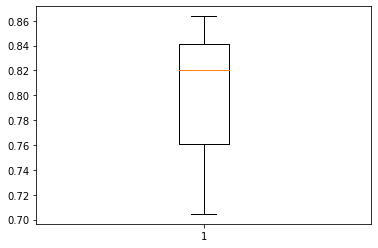

SCORE: Mean = 80.02%, Standard Deviation = 5.2%
95% Confidence Interval: 69.61% to 90.43%.


In [174]:
results = cross_val_score(gb_classifier_tuned,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

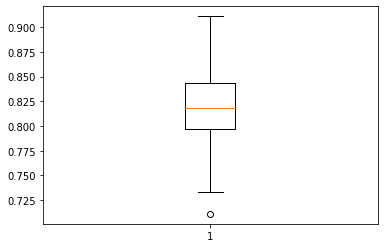

SCORE: Mean = 81.17%, Standard Deviation = 5.44%
95% Confidence Interval: 70.29% to 92.06%.


In [175]:
results = cross_val_score(gb_classifier_tuned,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [148]:
FinalModel = pd.DataFrame([test,gb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('gb_xgb1.csv',index=False)

# HOLY SHIT! SCORE: 0.78947!!! We're in the top 900!!!! I still have some tricks up my sleeve...

In [176]:
from sklearn.ensemble import StackingClassifier

In [184]:
estimators=[('Gradient Boosting', gb_classifier_tuned)]
final_estimator=initial

stacking_estimator=StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('Gradient Boosting',
                                GradientBoostingClassifier(init=XGBClassifier(base_score=0.5,
                                                                              booster='gbtree',
                                                                              callbacks=None,
                                                                              colsample_bylevel=0.6,
                                                                              colsample_bynode=0.5,
                                                                              colsample_bytree=0.8,
                                                                              early_stopping_rounds=None,
                                                                              enable_categorical=False,
                                                                              eval_metric=None,
                               

These metrics are performed on the Validation set.

Accuracy on training set :  0.8539325842696629
Accuracy on val/test set :  0.8542600896860987

Recall on training set :  0.6900584795321637
Recall on val/test set :  0.7076023391812866
Precision on training set :  0.9076923076923077
Precision on val/test set :  0.8897058823529411
F1 on training set :  0.7840531561461793
F1 on val/test set :  0.7882736156351791

Specificity on training set :  0.9562043795620438
Specificity on val/test set :  0.9454545454545454
NPV on training set :  0.8317460317460318
NPV on val/test set :  0.8387096774193549
Inverted F1 on training set :  0.8896434634974535
Inverted F1 on val/test set :  0.8888888888888888

Harmonic Mean of F1 and Inverted F1 on train set :  0.8335175649079292
Harmonic Mean of F1 and Inverted F1 on val/test set :  0.8355632283124731


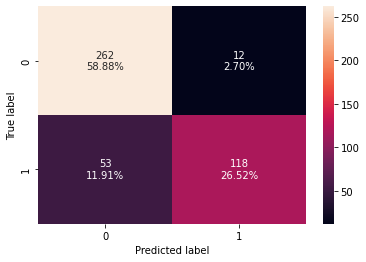

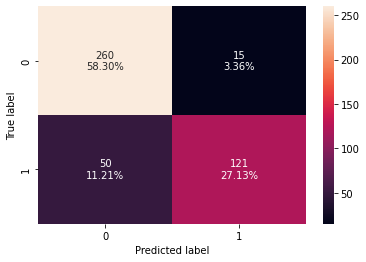

In [185]:
confusion_matrix_sklearn(stacking_estimator,X_train,y_train)

confusion_matrix_sklearn(stacking_estimator,X_val,y_val)

stacking_classifier_posttune = get_metrics_score(stacking_estimator, xtest=X_val, ytest=y_val)

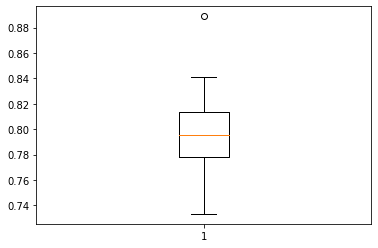

SCORE: Mean = 79.78%, Standard Deviation = 4.22%
95% Confidence Interval: 71.33% to 88.22%.


In [186]:
results = cross_val_score(stacking_estimator,X_train,y_train,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

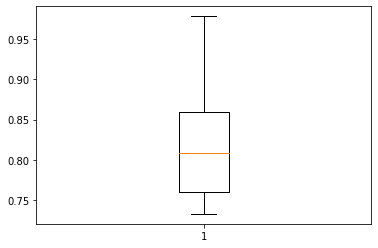

SCORE: Mean = 82.07%, Standard Deviation = 7.1%
95% Confidence Interval: 67.86% to 96.28%.


In [187]:
results = cross_val_score(stacking_estimator,X_val,y_val,cv=kFold,scoring=scoring,n_jobs=-1)

plt.boxplot(results)
plt.show()

print(f"SCORE: Mean = {round(results.mean()*100,2)}%, Standard Deviation = {round(results.std()*100,2)}%")

print(f"95% Confidence Interval: {round(100*(results.mean() - 2*(results.std())),2)}% to {round(100*(results.mean() + 2*(results.std())),2)}%.")

In [188]:
FinalModel = pd.DataFrame([test,gb_classifier_tuned.predict(X_test)]).T.rename(columns={'Unnamed 0':'Survived'})
FinalModel.to_csv('stacking.csv',index=False)

## It tied my best GradientBoost init XGBoost model! Well, That's pretty much all I'm gonna do for this  competition. It was fun, but at some point I've gotta move on.

## Ended at 902nd place!

In [190]:
from matplotlib import image
import matplotlib.pyplot as plt

final = image.imread('/kaggle/input/finalplacement/untitled.jpg')

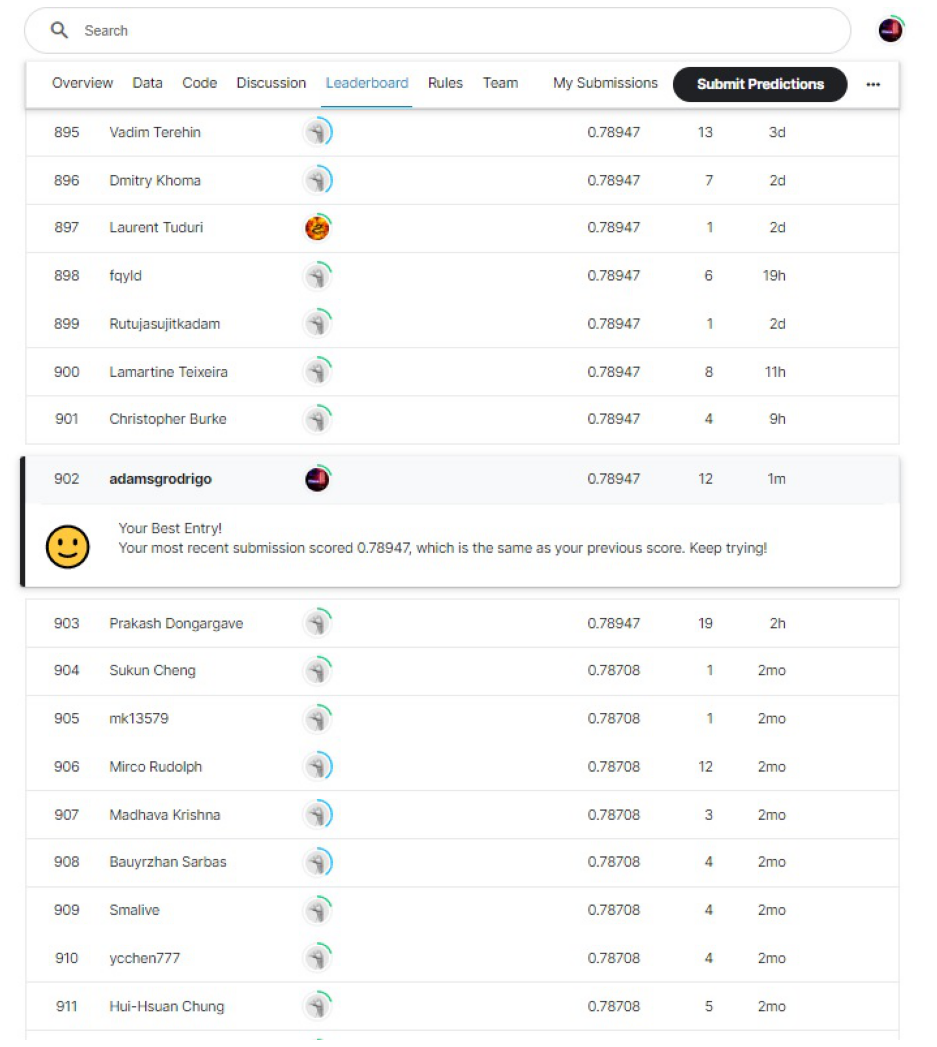

In [192]:
plt.imshow(final)
plt.axis('off')
plt.gcf().set_size_inches(19,19)